In [100]:
import copy
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from boostedhh import utils, hh_vars, plotting
from boostedhh.utils import PAD_VAL
from bbtautau import bbtautau_vars

import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger("boostedhh.utils")
logger.setLevel(logging.DEBUG)

plt.style.use(hep.style.CMS)
hep.style.use("CMS")

In [101]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
MAIN_DIR = Path("../../../")
CHANNEL = "electron"  # options: "hadronic", "electron", "muon"

plot_dir = MAIN_DIR / f"plots/SensitivityStudy/25Mar7{CHANNEL}"
plot_dir.mkdir(parents=True, exist_ok=True)

years = ["2022"]  # ["2023","2023BPix"]  # "2022","2022EE",

tags = {
    "data": {
        "2022": "24Nov21ParTMass_v12_private_signal",
        "2022EE": "25Jan22AddYears_v12_private_signal",
        "2023": "25Mar7Signal_v12_private_signal",
        "2023BPix": "25Mar7Signal_v12_private_signal",
    },
    "signal": {
        "2022": "24Nov21ParTMass_v12_private_signal",
        "2022EE": "25Jan22AddYears_v12_private_signal",
        "2023": "25Mar7Signal_v12_private_signal",
        "2023BPix": "25Mar7Signal_v12_private_signal",
    },
}

base_dir = {
    "2022": Path("/ceph/cms/store/user/rkansal/bbtautau/skimmer/"),
    "2022EE": Path("/ceph/cms/store/user/rkansal/bbtautau/skimmer/"),
    "2023": Path("/ceph/cms/store/user/lumori/bbtautau/skimmer/"),
    "2023BPix": Path("/ceph/cms/store/user/lumori/bbtautau/skimmer/"),
}

In [103]:
# pick signal key based on channel
SIG_KEYS = {"hadronic": "bbtthh", "electron": "bbtthe", "muon": "bbtthmu"}
SIG_KEY = SIG_KEYS[CHANNEL]

# pick relevant data samples based on channel
DATA_KEYS = {
    "hadronic": ["jetmet", "tau"],
    "electron": ["jetmet", "tau", "egamma"],
    "muon": ["jetmet", "tau", "muon"],
}[CHANNEL]

# pick relevant lepton dataset based on channel
LEPTON_DATASET = {"hadronic": None, "electron": "egamma", "muon": "muon"}[CHANNEL]

ALL_TRIGGERS = {
    "hadronic": bbtautau_vars.HLT_hh,
    "muon": bbtautau_vars.HLT_hmu,
    "electron": bbtautau_vars.HLT_he,
}

LEPTON_TRIGGERS = {
    "hadronic": None,
    "electron": bbtautau_vars.HLT_he,
    "muon": bbtautau_vars.HLT_hmu,
}

In [104]:
qcdouts = ["QCD0HF", "QCD1HF", "QCD2HF"]
topouts = ["TopW", "TopbW", "TopbWev", "TopbWmv", "TopbWtauhv", "TopbWq", "TopbWqq"]
sigouts = ["Xtauhtauh", "Xtauhtaue", "Xtauhtaum", "Xbb"]

columns_data = {
    year: [
        ("weight", 1),
        ("ak8FatJetMsd", 3),
        ("ak8FatJetEta", 3),
        ("ak8FatJetPt", 3),
        ("ak8FatJetPhi", 3),
        ("ak8FatJetPNetXbbLegacy", 3),
        ("ak8FatJetPNetQCDLegacy", 3),
        ("ak8FatJetPNetmassLegacy", 3),
        ("ak8FatJetParTmassResApplied", 3),
        ("ak8FatJetParTmassVisApplied", 3),
    ]
    for year in years
}


columns_signal = copy.deepcopy(columns_data)

for year in years:
    for branch in ALL_TRIGGERS[CHANNEL][year]:
        columns_data[year].append((branch, 1))
        columns_signal[year].append((branch, 1))

    for branch in [f"ak8FatJetParT{key}" for key in qcdouts + topouts + sigouts]:
        columns_data[year].append((branch, 3))
        columns_signal[year].append((branch, 3))

    columns_signal[year] += [
        ("GenTauhh", 1),
        ("GenTauhmu", 1),
        ("GenTauhe", 1),
        ("GenHiggsEta", 2),
        ("GenHiggsPt", 2),
        ("GenHiggsPhi", 2),
        ("GenHiggsMass", 2),
        ("GenbbEta", 2),
        ("GenbbPt", 2),
        ("GenbbPhi", 2),
        ("GenbbMass", 2),
        ("GenTauEta", 2),
        ("GenTauPt", 2),
        ("GenTauPhi", 2),
        ("GenTauMass", 2),
        ("single_weight_genweight", 1),
        ("single_weight_pileup", 1),
        ("single_weight_ISRPartonShower", 1),
        ("single_weight_FSRPartonShower", 1),
    ]

## Define and load samples

In [105]:
# define samples to load
samples = {
    year: {
        "jetmet": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="JetHT|JetMET",
            label="JetMET",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "tau": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="Tau_Run",
            label="Tau",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "muon": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="Muon_Run",
            label="Muon",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "egamma": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="EGamma_Run",
            label="EGamma",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "bbtt": utils.Sample(
            path=base_dir[year] / tags["signal"][year],
            selector=hh_vars.bbtt_sigs["bbtt"][year],
            label=r"HHbb$\tau\tau$",
            isData=False,
            year=year,
            load_columns=utils.format_columns(columns_signal[year]),
        ),
    }
    for year in years
}

for key in ["jetmet", "tau", "egamma", "muon"]:
    if key not in DATA_KEYS:
        for year in years:
            del samples[year][key]

In [106]:
# pt_cut = 250
# msd_cut = 40

filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", 250),
        ("('ak8FatJetPNetmassLegacy', '0')", ">=", 50),
        ("('ak8FatJetPt', '1')", ">=", 200),
        # ("('ak8FatJetMsd', '0')", ">=", msd_cut),
        # ("('ak8FatJetMsd', '1')", ">=", msd_cut),
        # ("('ak8FatJetPNetXbb', '0')", ">=", 0.8),
    ],
]


# dictionary that will contain all information (from all samples)
events_dict = {year: {} for year in years}

for year in years:
    for key, sample in samples[year].items():
        events_dict[year][key] = utils.load_sample(sample, filters)

    events_dict[year]["bbtthh"] = events_dict[year]["bbtt"][
        events_dict[year]["bbtt"]["GenTauhh"][0]
    ]
    events_dict[year]["bbtthmu"] = events_dict[year]["bbtt"][
        events_dict[year]["bbtt"]["GenTauhmu"][0]
    ]
    events_dict[year]["bbtthe"] = events_dict[year]["bbtt"][
        events_dict[year]["bbtt"]["GenTauhe"][0]
    ]
    del events_dict[year]["bbtt"]


cutflow = {year: pd.DataFrame(index=list(events_dict[year].keys())) for year in years}

for year in years:
    utils.add_to_cutflow(events_dict[year], "Preselection", "finalWeight", cutflow[year])

2025-04-03 17:53:10,392 - INFO - Loading ['JetHT_Run2022C', 'JetMET_Run2022D', 'JetMET_Run2022C']
2025-04-03 17:53:10,392 - DEBUG - Loading JetHT_Run2022C
2025-04-03 17:53:11,018 - INFO - Loaded JetHT_Run2022C                                    : 2150129 entries
2025-04-03 17:53:11,019 - DEBUG - Loading JetMET_Run2022D
2025-04-03 17:53:12,364 - INFO - Loaded JetMET_Run2022D                                   : 7859902 entries
2025-04-03 17:53:12,365 - DEBUG - Loading JetMET_Run2022C
2025-04-03 17:53:15,491 - INFO - Loaded JetMET_Run2022C                                   : 18688179 entries
2025-04-03 17:53:21,058 - INFO - Loading ['Tau_Run2022C', 'Tau_Run2022D']
2025-04-03 17:53:21,059 - DEBUG - Loading Tau_Run2022C
2025-04-03 17:53:22,395 - INFO - Loaded Tau_Run2022C                                      : 697018 entries
2025-04-03 17:53:22,396 - DEBUG - Loading Tau_Run2022D
2025-04-03 17:53:22,777 - INFO - Loaded Tau_Run2022D                                      : 427792 entries
2025-0

## Triggers

In [ ]:
for year in years:
    print(year)
    for skey in SIG_KEYS.values():
        print(skey)
        triggered = np.sum(
            [events_dict[year][skey][hlt].iloc[:, 0] for hlt in ALL_TRIGGERS[CHANNEL][year]],
            axis=0,
        ).astype(bool)
        events_dict[year][skey] = events_dict[year][skey][triggered]

2023
bbtthh
bbtthe
bbtthmu
2023BPix
bbtthh
bbtthe
bbtthmu


### Data (overlap removal)

In [ ]:
trigdict = {year: {"jetmet": {}, "tau": {}} for year in years}

if LEPTON_DATASET:
    for year in years:
        trigdict[year][LEPTON_DATASET] = {}

for year in years:
    for key, d in trigdict[year].items():
        d["all"] = np.sum(
            [events_dict[year][key][hlt].iloc[:, 0] for hlt in ALL_TRIGGERS[CHANNEL][year]], axis=0
        ).astype(bool)
        d["jets"] = np.sum(
            [
                events_dict[year][key][hlt].iloc[:, 0]
                for hlt in bbtautau_vars.HLT_dict[year]["PNet"]
                + bbtautau_vars.HLT_dict[year]["PFJet"]
            ],
            axis=0,
        ).astype(bool)
        d["taus"] = np.sum(
            [events_dict[year][key][hlt].iloc[:, 0] for hlt in bbtautau_vars.HLT_taus[year]], axis=0
        ).astype(bool)

        d["taunojets"] = ~d["jets"] & d["taus"]

        if LEPTON_DATASET:
            d[LEPTON_DATASET] = np.sum(
                [events_dict[year][key][hlt].iloc[:, 0] for hlt in LEPTON_TRIGGERS[CHANNEL][year]],
                axis=0,
            ).astype(bool)

            d[f"{LEPTON_DATASET}noothers"] = ~d["jets"] & ~d["taus"] & d[LEPTON_DATASET]

Checking event loss by flipping triggers (can skip)

In [ ]:
# xor = np.setdiff1d(
#     events_dict["jetmet"][trigdict["jetmet"]["nojettau"]]["event"][0],
#     events_dict["tau"][trigdict["tau"]["nojettau"]]["event"][0],
# )

# print(len(xor) / len(events_dict["jetmet"]))

# xor = np.setdiff1d(
#     events_dict["tau"][trigdict["tau"]["jetnotau"]]["event"][0],
#     events_dict["jetmet"][trigdict["jetmet"]["jets"]]["event"][0],
# )

# print(len(xor) / len(events_dict["tau"]))

Apply overlap removal

In [ ]:
for year in years:
    events_dict[year]["jetmet"] = events_dict[year]["jetmet"][trigdict[year]["jetmet"]["jets"]]
    events_dict[year]["tau"] = events_dict[year]["tau"][trigdict[year]["tau"]["taunojets"]]
    if LEPTON_DATASET:
        events_dict[year][LEPTON_DATASET] = events_dict[year][LEPTON_DATASET][
            trigdict[year][LEPTON_DATASET][f"{LEPTON_DATASET}noothers"]
        ]

In [ ]:
for year in years:
    utils.add_to_cutflow(events_dict[year], "Triggers", "finalWeight", cutflow[year])
cutflow

{'2023':          Preselection      Triggers
 jetmet   3.080492e+07  1.513714e+07
 tau      2.477410e+06  1.249548e+06
 bbtthh   5.384445e-01  4.818363e-01
 bbtthmu  2.234062e-01  1.848533e-01
 bbtthe   2.347330e-01  2.068110e-01,
 '2023BPix':          Preselection      Triggers
 jetmet   1.286855e+07  6.062770e+06
 tau      1.312411e+06  7.647510e+05
 bbtthh   2.910912e-01  2.607272e-01
 bbtthmu  1.165935e-01  9.538858e-02
 bbtthe   1.268147e-01  1.124542e-01}

## FatJet Gen Matching

In [ ]:
# merge years in gen matching
events = pd.concat([events_dict[year][SIG_KEY] for year in years], keys=[year for year in years])

higgs = utils.make_vector(events, "GenHiggs")
bb = utils.make_vector(events, "Genbb")
tt = utils.make_vector(events, "GenTau")
fatjets = utils.make_vector(events, "ak8FatJet", mstring="Msd")

events

weight ak8FatJetMsd                          ak8FatJetEta  \
                       0            0          1             2            0   
2023     2      2.341593    96.125000  35.593750 -99999.000000     1.021729   
         3      4.469487   107.937500   0.603516      1.352539     0.832520   
         4      1.968218   131.250000  70.062500 -99999.000000     0.677124   
         7      1.338461   121.375000  74.500000 -99999.000000     1.712646   
         8      3.675716    50.750000   0.629883 -99999.000000    -0.133942   
...                  ...          ...        ...           ...          ...   
2023BPix 36774  0.306796   111.500000   4.949219      1.464844    -0.637451   
         36777  1.254441     0.798340  64.562500 -99999.000000     1.272949   
         36779  1.242393   128.875000  49.625000 -99999.000000     1.412109   
         36780  0.167337     0.143433   4.554688 -99999.000000     0.814087   
         36781  1.265210   125.500000   0.149902 -99999.000000     1.478516   

                                       ak8FatJetPt                            \
                       1             2           0           1             2   
2023     2      1.553955 -99999.000000  274.211670  212.380600 -99999.000000   
         3      0.905518      2.298340  330.003357  324.869415    251.672043   
         4      0.266174 -99999.000000  328.181763  202.358490 -99999.000000   
         7      0.684204 -99999.000000  382.790833  253.326080 -99999.000000   
         8      1.117432 -99999.000000  255.289566  242.229691 -99999.000000   
...                  ...           ...         ...         ...           ...   
2023BPix 36774 -0.889771      0.754028  499.479095  348.438110    218.544769   
         36777  0.621704 -99999.000000  426.999756  202.664871 -99999.000000   
         36779  1.476318 -99999.000000  339.772552  271.885986 -99999.000000   
         36780 -0.439514 -99999.000000  331.970459  235.872757 -99999.000000   
         36781  1.292969 -99999.000000  286.405762  228.487946 -99999.000000   

                ... GenTauPhi           GenTauMass       \
                ...         0         1          0    1   
2023     2      ...  1.246094  2.867188        0.0  0.0   
         3      ...  0.785156  1.468750        0.0  0.0   
         4      ... -1.003906 -0.931641        0.0  0.0   
         7      ...  1.585938  1.246094        0.0  0.0   
         8      ...  1.097656  2.695312        0.0  0.0   
...             ...       ...       ...        ...  ...   
2023BPix 36774  ...  3.023438 -2.992188        0.0  0.0   
         36777  ... -2.078125  1.191406        0.0  0.0   
         36779  ... -2.648438 -0.460938        0.0  0.0   
         36780  ...  1.332031 -0.169434        0.0  0.0   
         36781  ... -2.484375  2.960938        0.0  0.0   

               single_weight_genweight single_weight_pileup  \
                                     0                    0   
2023     2                    0.033119             1.607049   
         3                    0.033119             3.067434   
         4                    0.033119             1.350799   
         7                    0.033119             0.918594   
         8                    0.033119             2.522665   
...                                ...                  ...   
2023BPix 36774                0.033119             0.393219   
         36777                0.033119             1.607811   
         36779                0.033119             1.592369   
         36780                0.033119             0.214475   
         36781                0.033119             1.621613   

               single_weight_ISRPartonShower single_weight_FSRPartonShower  \
                                           0                             0   
2023     2                               1.0                           1.0   
         3                               1.0                           1.0   
         4                               1.0     

In [ ]:
minbb = np.min(higgs[:, 0:1].deltaR(bb), axis=1)
mintau = np.min(higgs[:, 0:1].deltaR(tt), axis=1)
genhbb1 = minbb < mintau

# minbb = np.min(higgs[:, 1:2].deltaR(bb), axis=1)
# mintau = np.min(higgs[:, 1:2].deltaR(tt), axis=1)
# genhbb2 = minbb < mintau  # overlap with genhb1 < 0.5% of the time

genhbb_mask = np.vstack([genhbb1, ~genhbb1]).T
genhbb = higgs[genhbb_mask]
genhtt = higgs[~genhbb_mask]

In [ ]:
fjbbdr = fatjets.deltaR(genhbb[:, np.newaxis])
fjidbb = np.argmin(fjbbdr, axis=1)
fjttdr = fatjets.deltaR(genhtt[:, np.newaxis])
fjidtt = np.argmin(fjttdr, axis=1)
# 5% of events have overlap out of which only 5% actually have two jets both close to a gen Higgs,
# so ignoring these overlap events for now
overlap = fjidbb == fjidtt

In [ ]:
np.mean(overlap)

0.04964422662866282

## Taggers

In [ ]:
taggers_dict = {year: {} for year in years}

taukey = {"hadronic": "Xtauhtauh", "electron": "Xtauhtaue", "muon": "Xtauhtaum"}[CHANNEL]

for year in years:
    for key, events in events_dict[year].items():
        tvars = {}

        qcdouts = ["QCD0HF", "QCD1HF", "QCD2HF"]  # HF = heavy flavor = {c,b}
        topouts = ["TopW", "TopbW"]  # "TopbWev", "TopbWmv", "TopbWtauhv", "TopbWq", "TopbWqq"]
        tvars["PQCD"] = sum([events[f"ak8FatJetParT{k}"] for k in qcdouts]).to_numpy()
        tvars["PTop"] = sum([events[f"ak8FatJetParT{k}"] for k in topouts]).to_numpy()

        for disc in ["Xbb", taukey]:
            tvars[f"{disc}vsQCD"] = np.nan_to_num(
                events[f"ak8FatJetParT{disc}"] / (events[f"ak8FatJetParT{disc}"] + tvars["PQCD"]),
                nan=PAD_VAL,
            )
            tvars[f"{disc}vsQCDTop"] = np.nan_to_num(
                events[f"ak8FatJetParT{disc}"]
                / (events[f"ak8FatJetParT{disc}"] + tvars["PQCD"] + tvars["PTop"]),
                nan=PAD_VAL,
            )

            # make sure not to choose padded jets below by accident
            nojet3 = events["ak8FatJetPt"][2] == PAD_VAL
            tvars[f"{disc}vsQCD"][:, 2][nojet3] = PAD_VAL
            tvars[f"{disc}vsQCDTop"][:, 2][nojet3] = PAD_VAL

        tvars["PNetXbbvsQCD"] = np.nan_to_num(
            events["ak8FatJetPNetXbbLegacy"]
            / (events["ak8FatJetPNetXbbLegacy"] + events["ak8FatJetPNetQCDLegacy"]),
            nan=PAD_VAL,
        )

        # jet assignment
        fjbbpick = np.argmax(tvars["XbbvsQCD"], axis=1)
        fjttpick = np.argmax(tvars[f"{taukey}vsQCD"], axis=1)
        overlap = fjbbpick == fjttpick
        fjbbpick[overlap] = np.argsort(tvars["XbbvsQCD"][overlap], axis=1)[:, -2]

        # convert ids to boolean masks
        fjbbpick_mask = np.zeros_like(tvars["XbbvsQCD"], dtype=bool)
        fjbbpick_mask[np.arange(len(fjbbpick)), fjbbpick] = True
        fjttpick_mask = np.zeros_like(tvars[f"{taukey}vsQCD"], dtype=bool)
        fjttpick_mask[np.arange(len(fjttpick)), fjttpick] = True

        tvars["bb_mask"] = fjbbpick_mask
        tvars["tautau_mask"] = fjttpick_mask
        taggers_dict[year][key] = tvars

Checking bb matching accuracy (can skip)

In [ ]:
tvars = {}
if len(years) > 1:
    for key in taggers_dict[years[0]][SIG_KEY].keys():
        tvars[key] = np.concatenate([taggers_dict[year][SIG_KEY][key] for year in years])
else:
    tvars = taggers_dict[years[0]][SIG_KEY]

maxtxbb = np.max(tvars["XbbvsQCD"], axis=1)
fjbbpick = np.argmax(tvars["XbbvsQCD"], axis=1)
maxtxtt = np.max(tvars[f"{taukey}vsQCD"], axis=1)
fjttpick = np.argmax(tvars[f"{taukey}vsQCD"], axis=1)

# how many are assigned correctly?
print(f"Correct matching bb: {np.mean(fjbbpick == fjidbb)}")
print(f"Correct matching tt: {np.mean(fjttpick == fjidtt)}")

overlap = fjbbpick == fjttpick
print(f"Overlap: {np.mean(overlap)}")
# how many pass reasonable tagger cuts?
print(
    f"How many overlaps pass basic tagger cuts: {np.sum((maxtxbb > 0.8) * (maxtxtt > 0.95) * overlap) / np.sum(overlap)}"
)  # <0.1%

Correct matching bb: 0.893862653023561
Correct matching tt: 0.9514425738716755
Overlap: 0.16172821785223615
How many overlaps pass basic tagger cuts: 0.004057309496640041


In [ ]:
def get_jet_vals(vals, mask):
    # check if vals is a numpy array
    if not isinstance(vals, np.ndarray):
        vals = vals.to_numpy()

    return vals[mask]

### ROC Curves

In [ ]:
from sklearn.metrics import roc_curve


def compute_rocs(
    years,
    jets=["bb", "tautau"],
    discs=["XbbvsQCD", "XbbvsQCDTop", f"{taukey}vsQCD", f"{taukey}vsQCDTop", "PNetXbbvsQCD"],
):

    rocs = {}

    for jet in jets:
        print(jet)
        rocs[jet] = {}
        for i, disc in enumerate(discs):
            print("\t" + disc)

            bg_scores = np.concatenate(
                [
                    get_jet_vals(
                        taggers_dict[year][key][disc], taggers_dict[year][key][f"{jet}_mask"]
                    )
                    for key in DATA_KEYS
                    for year in years
                ]
            )
            bg_weights = np.concatenate(
                [events_dict[year][key]["finalWeight"] for key in DATA_KEYS for year in years]
            )

            sig_scores = np.concatenate(
                [
                    get_jet_vals(
                        taggers_dict[year][SIG_KEY][disc],
                        taggers_dict[year][SIG_KEY][f"{jet}_mask"],
                    )
                    for year in years
                ]
            )
            sig_weights = np.concatenate(
                [events_dict[year][SIG_KEY]["finalWeight"] for year in years]
            )

            fpr, tpr, thresholds = roc_curve(
                np.concatenate([np.zeros_like(bg_scores), np.ones_like(sig_scores)]),
                np.concatenate([bg_scores, sig_scores]),
                sample_weight=np.concatenate([bg_weights, sig_weights]),
            )

            rocs[jet][disc] = {
                "fpr": fpr,
                "tpr": tpr,
                "thresholds": thresholds,
                "label": disc,
                "color": plt.cm.tab10.colors[i],
            }

    return rocs

In [ ]:
rocs_full = compute_rocs(years)

bb
	XbbvsQCD
	XbbvsQCDTop
	XtauhtauhvsQCD
	XtauhtauhvsQCDTop
	PNetXbbvsQCD
tautau
	XbbvsQCD
	XbbvsQCDTop
	XtauhtauhvsQCD
	XtauhtauhvsQCDTop
	PNetXbbvsQCD


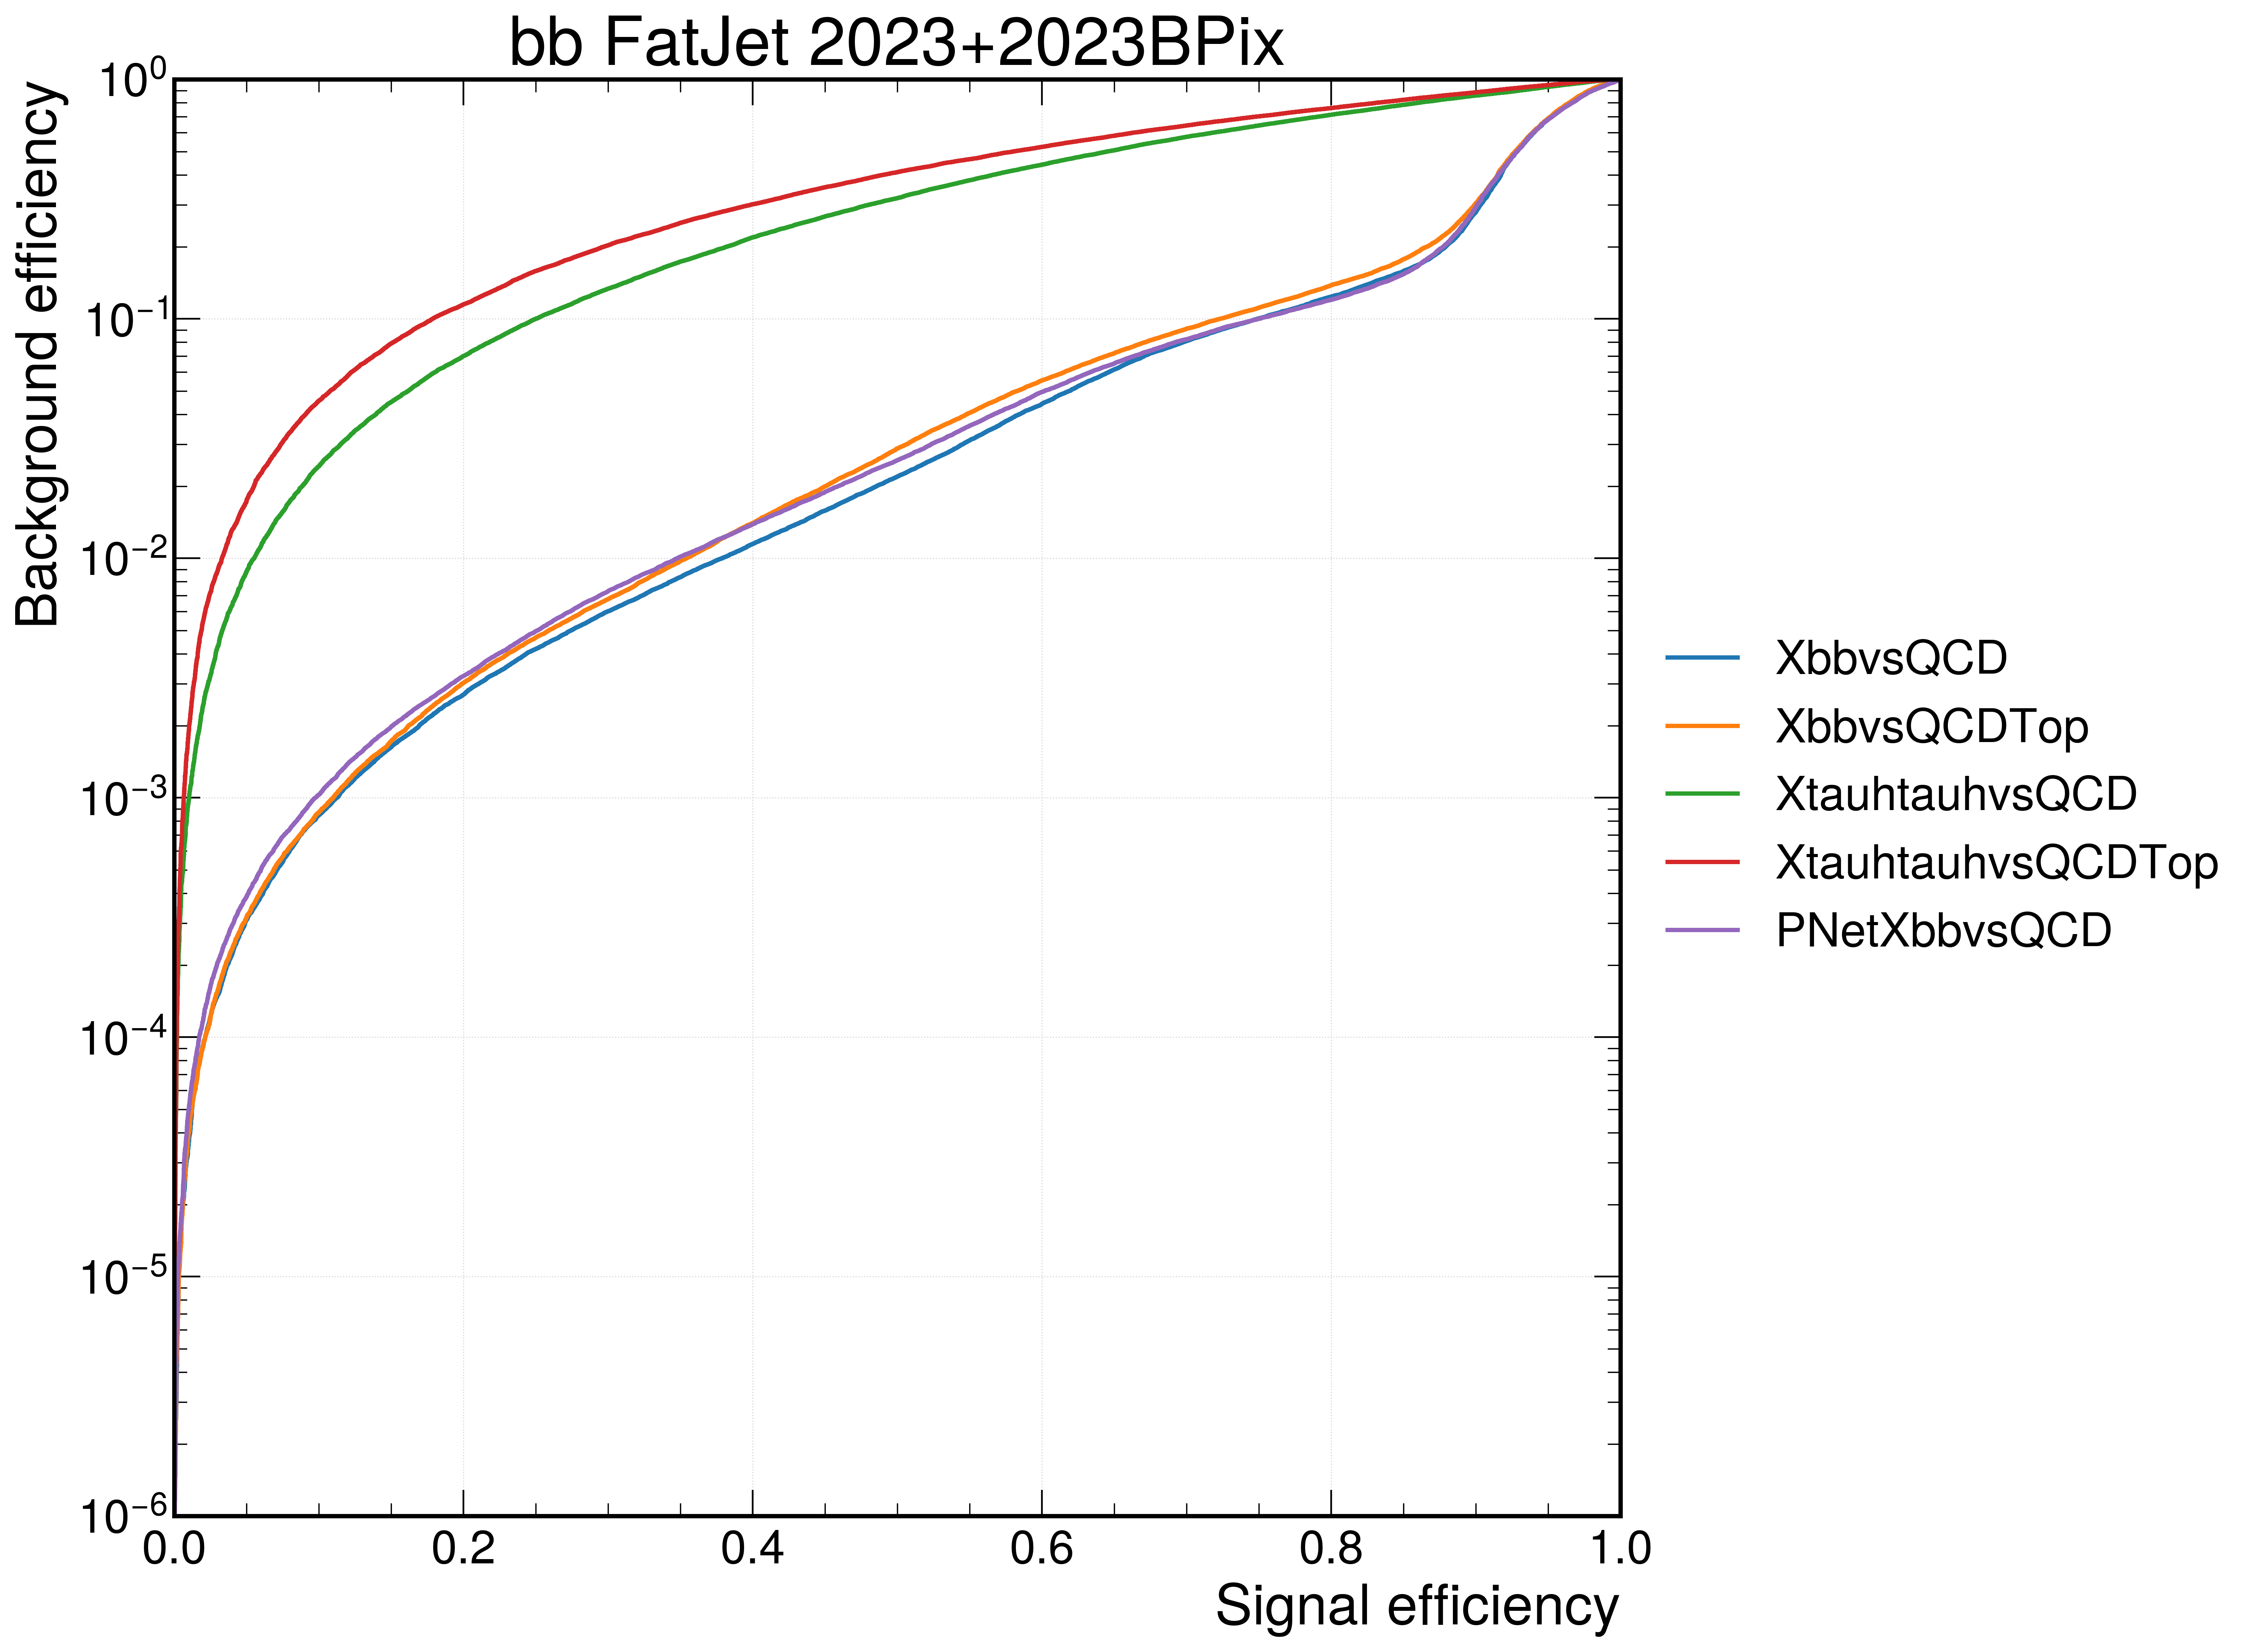

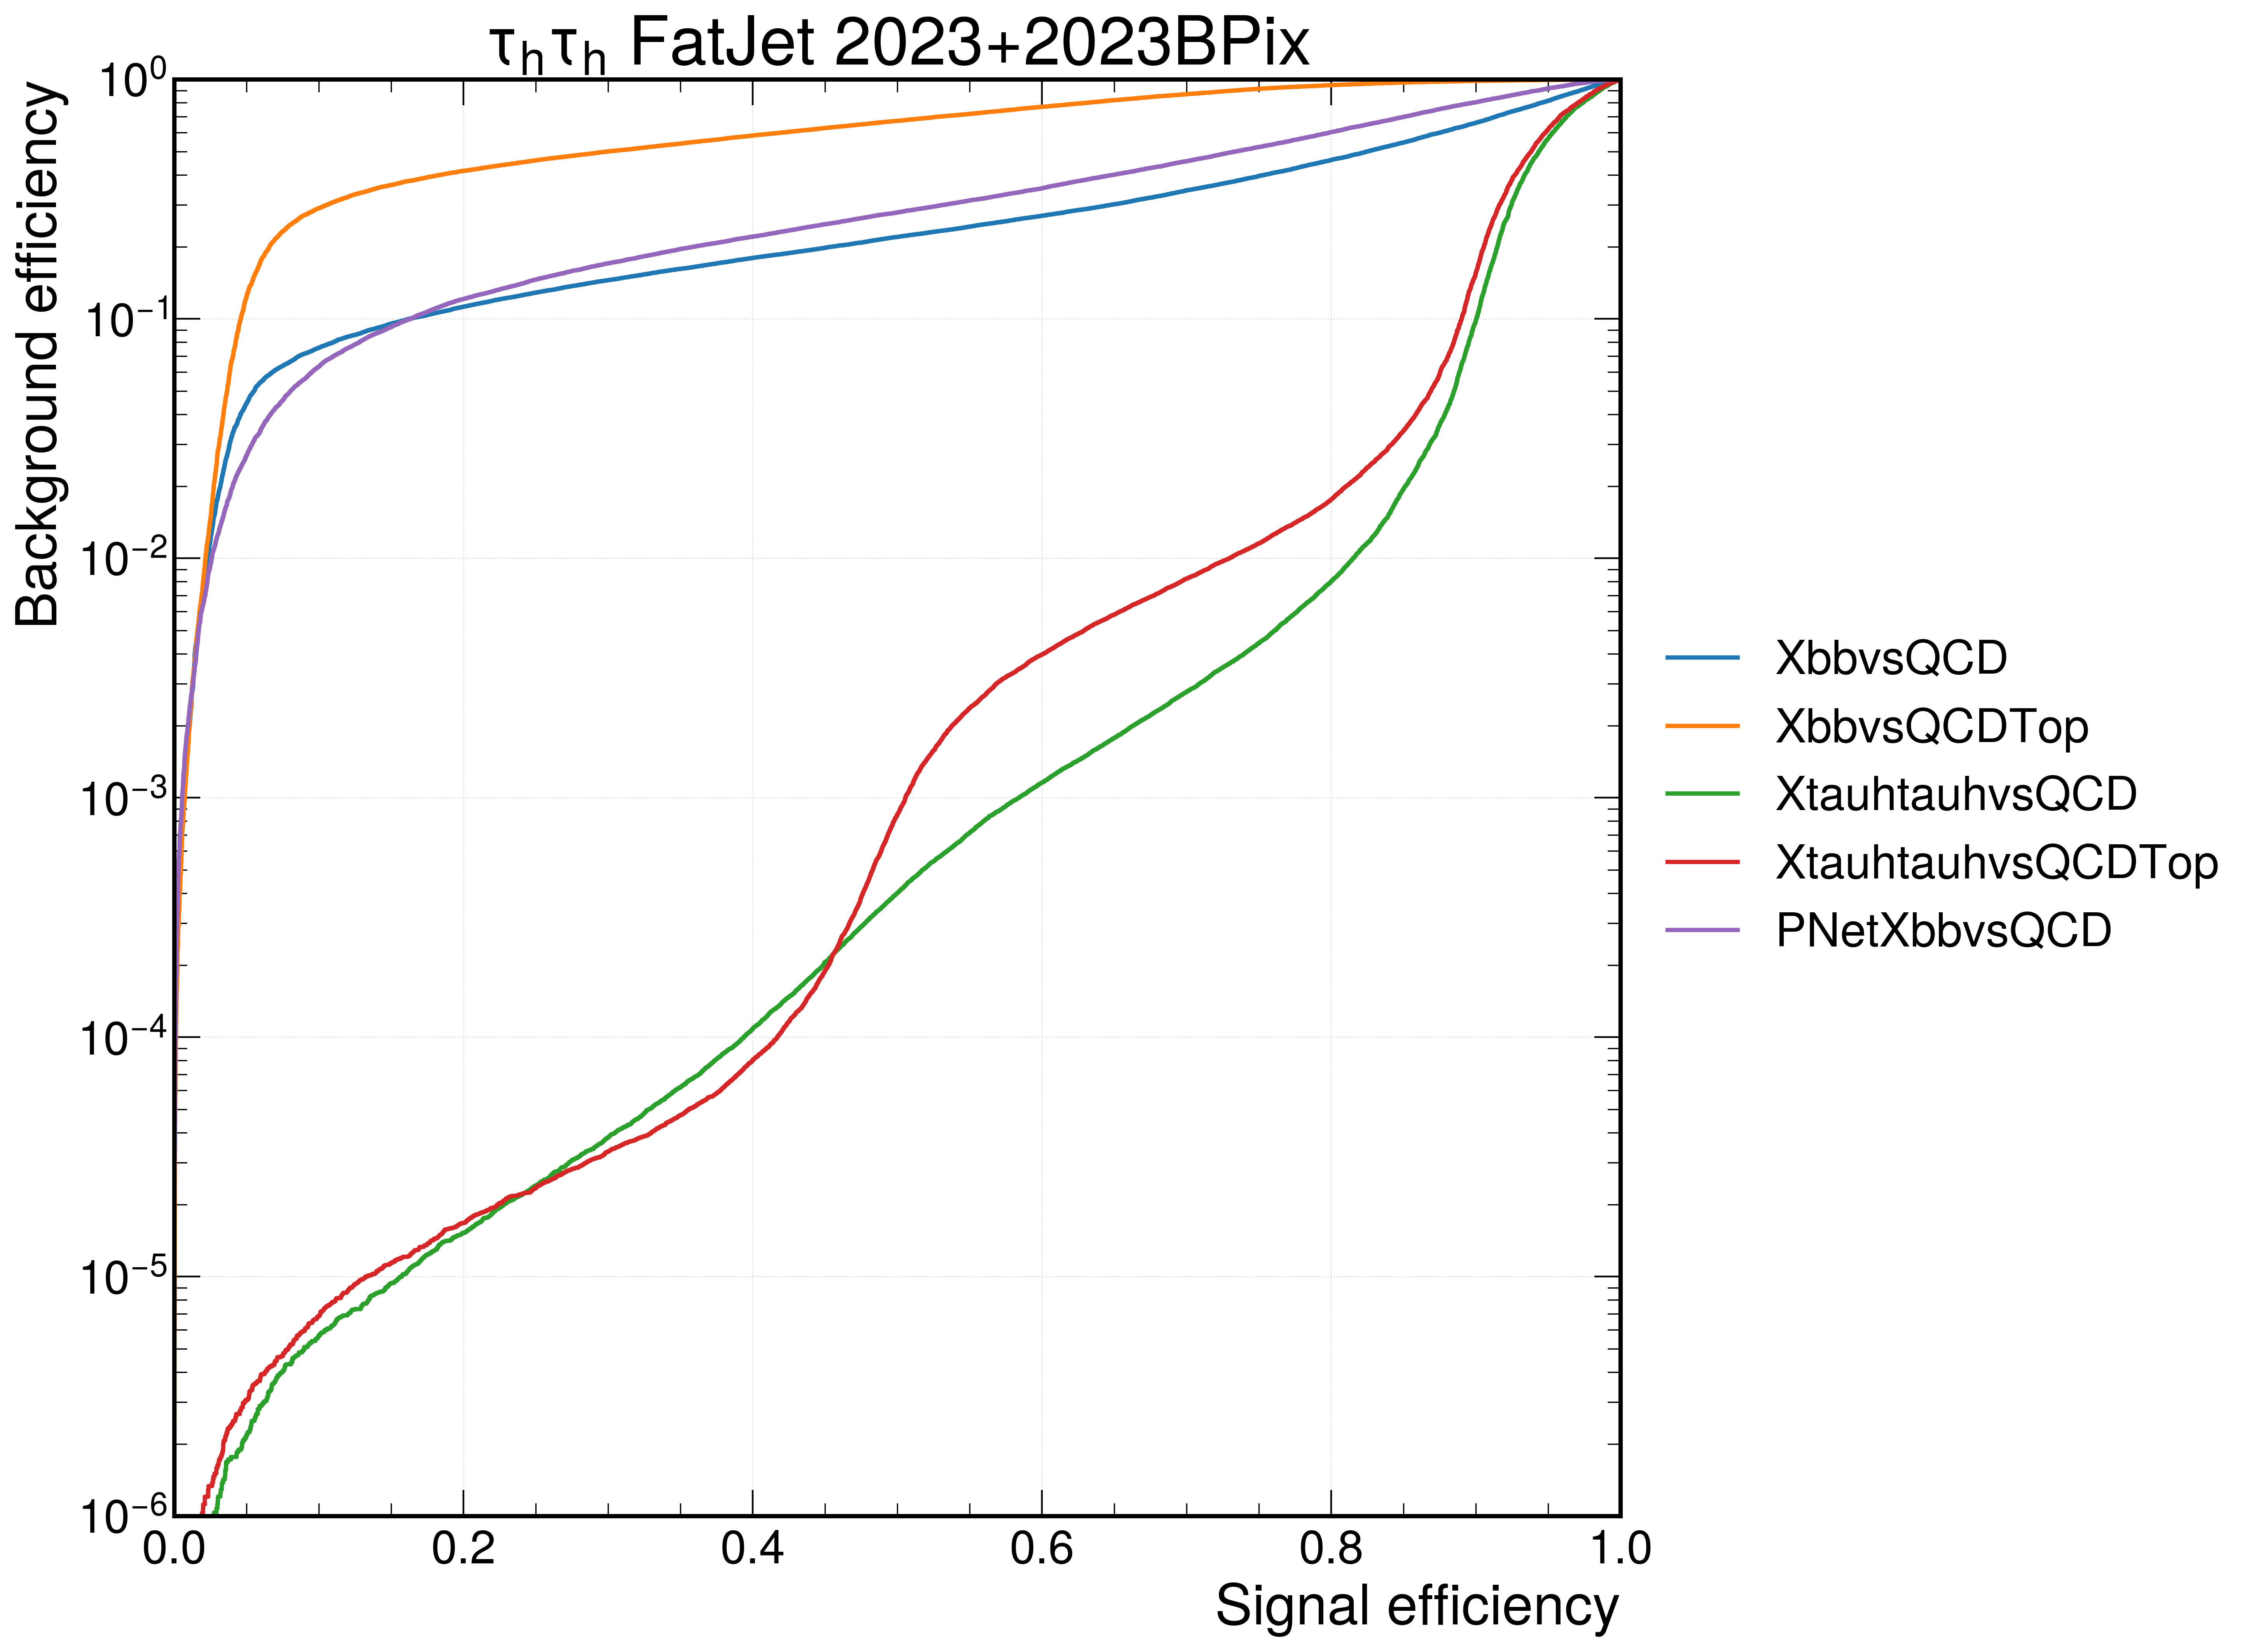

In [ ]:
for jet, title in zip(["bb", "tautau"], ["bb FatJet", rf"$\tau_h\tau_{CHANNEL[0]}$ FatJet"]):
    if len(years) > 1:
        for i, year in enumerate(years):
            if i == 0:
                title += f" {year}"
            else:
                title += f"+{year}"
    else:
        title = title + f" {years[0]}"

    plotting.multiROCCurveGrey(
        {"": rocs_full[jet]},
        title=title,
        show=True,
        plot_dir=plot_dir,
        name=f"roc_{jet} {years}",
    )

In [ ]:
rocs = {year: compute_rocs([year]) for year in years}

bb
	XbbvsQCD
	XbbvsQCDTop
	XtauhtauhvsQCD
	XtauhtauhvsQCDTop
	PNetXbbvsQCD
tautau
	XbbvsQCD
	XbbvsQCDTop
	XtauhtauhvsQCD
	XtauhtauhvsQCDTop
	PNetXbbvsQCD
bb
	XbbvsQCD
	XbbvsQCDTop
	XtauhtauhvsQCD
	XtauhtauhvsQCDTop
	PNetXbbvsQCD
tautau
	XbbvsQCD
	XbbvsQCDTop
	XtauhtauhvsQCD
	XtauhtauhvsQCDTop
	PNetXbbvsQCD


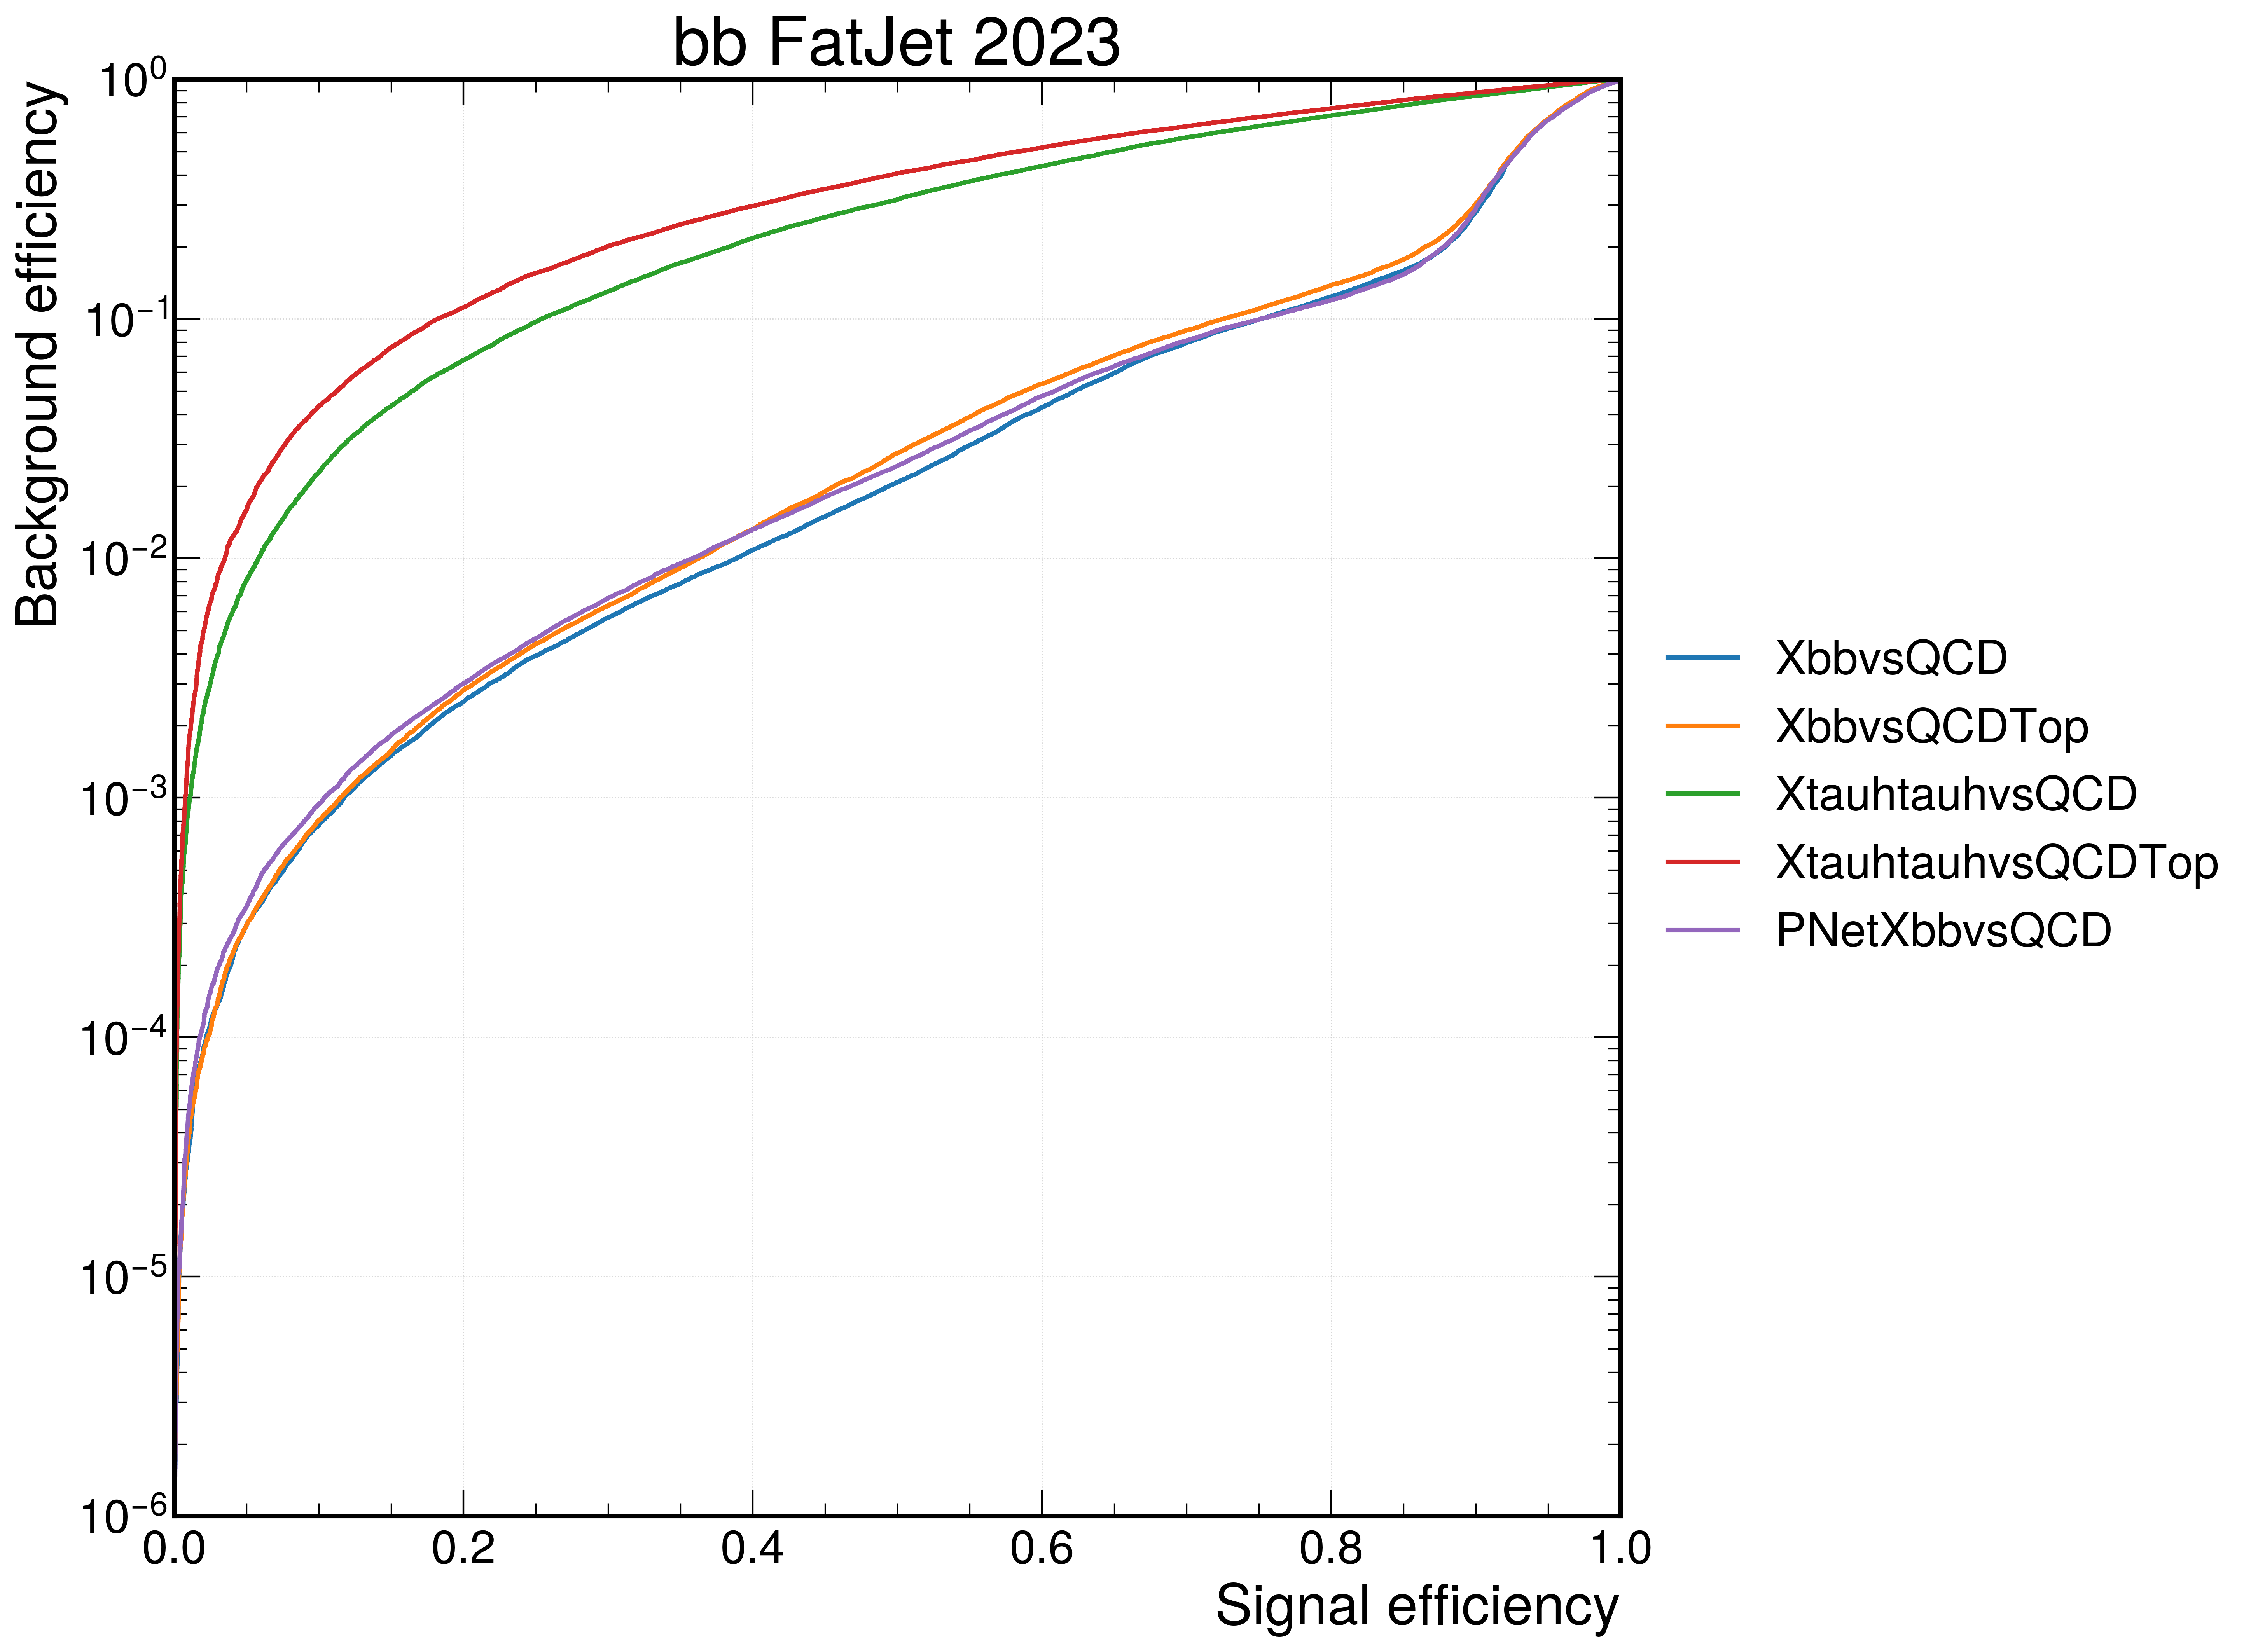

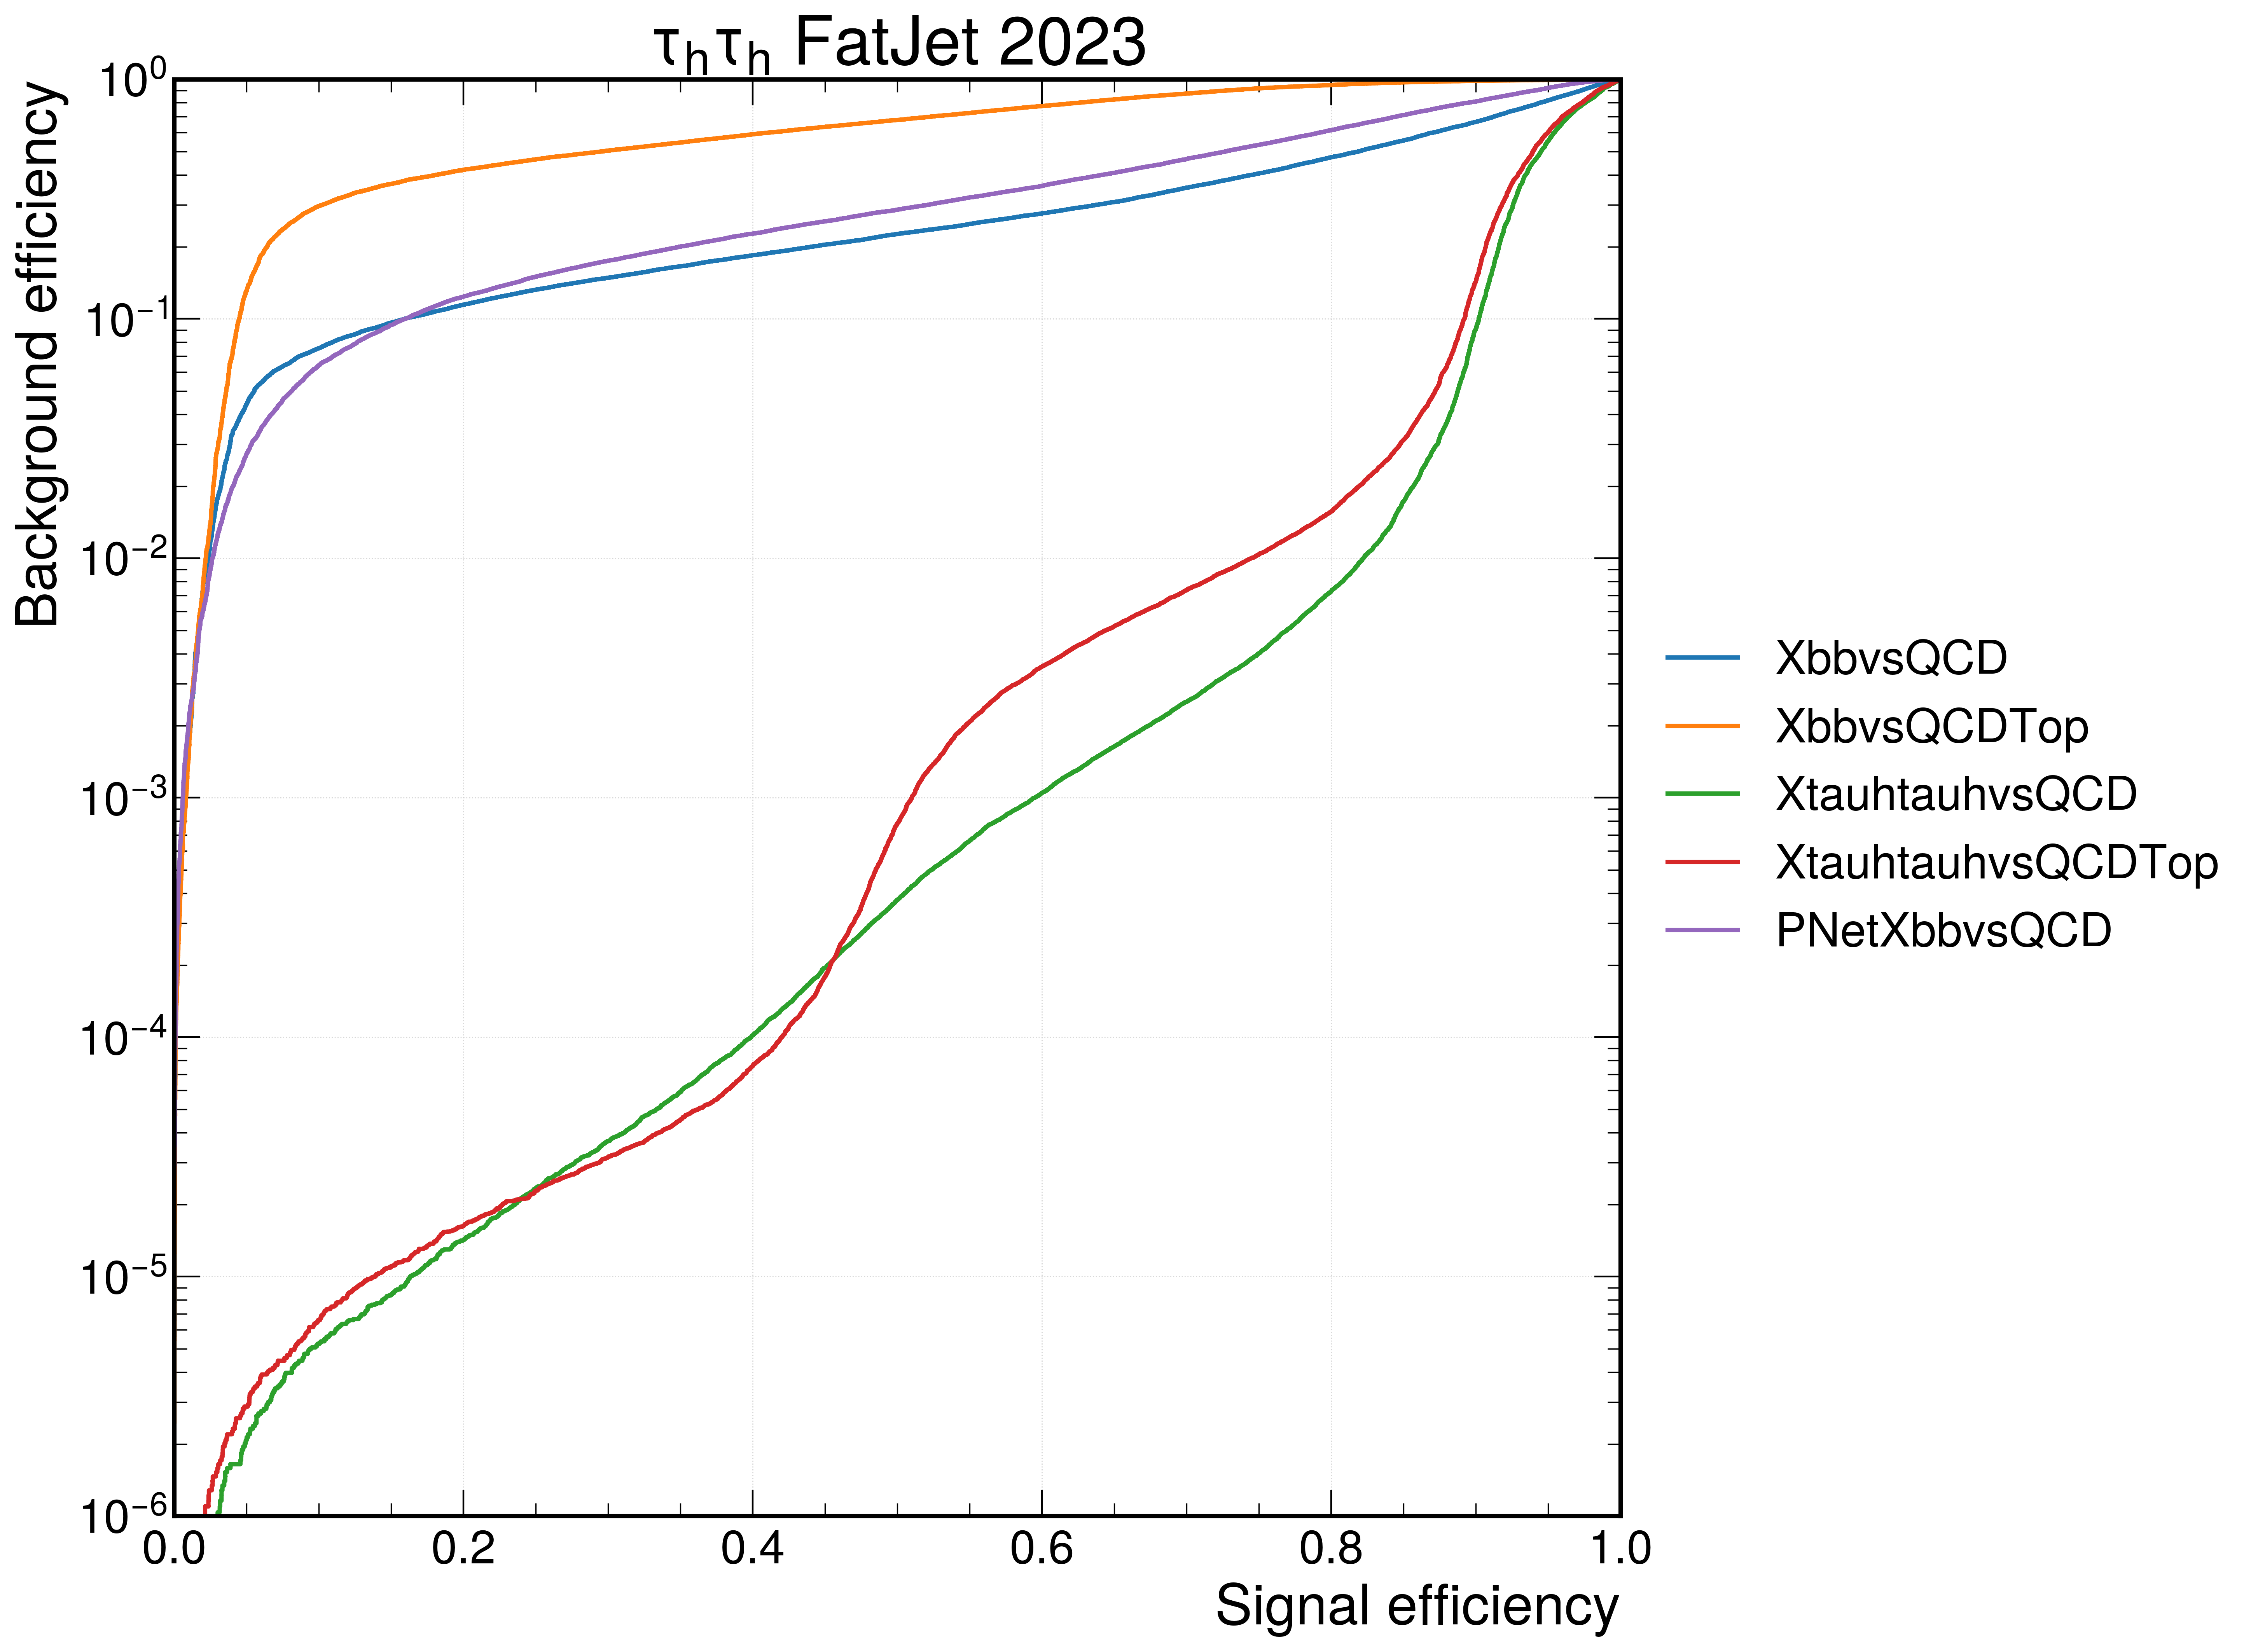

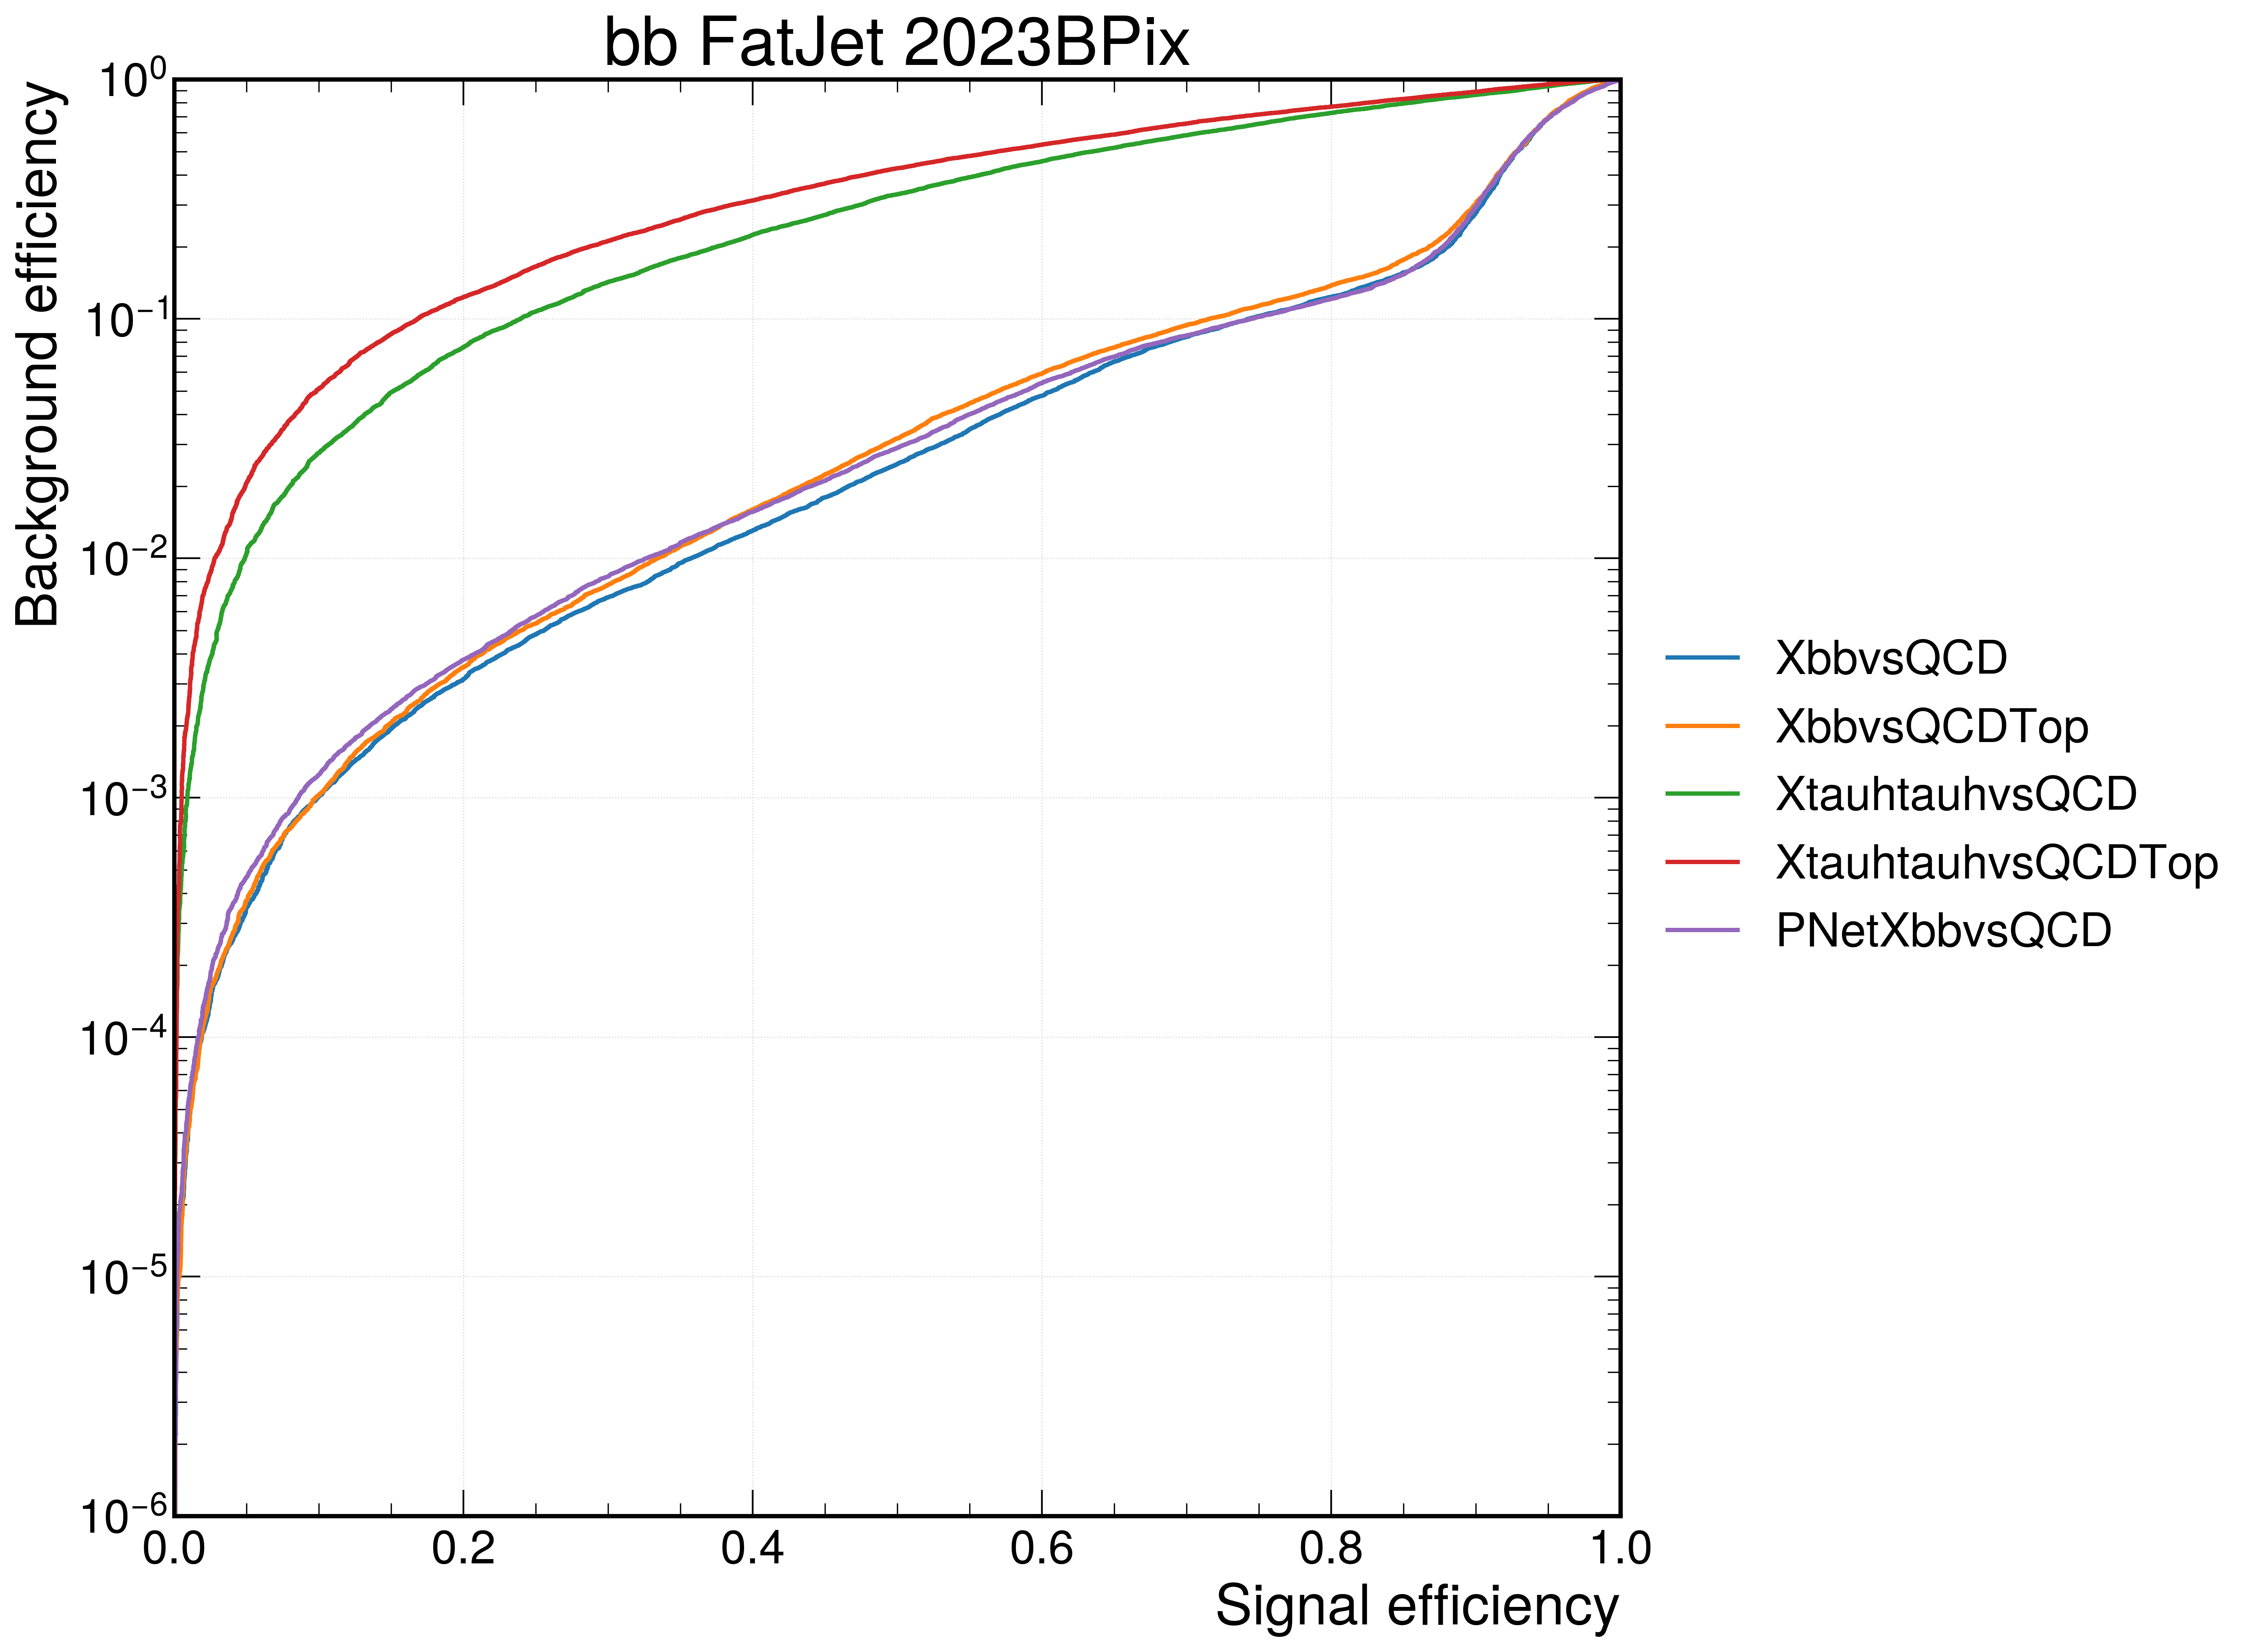

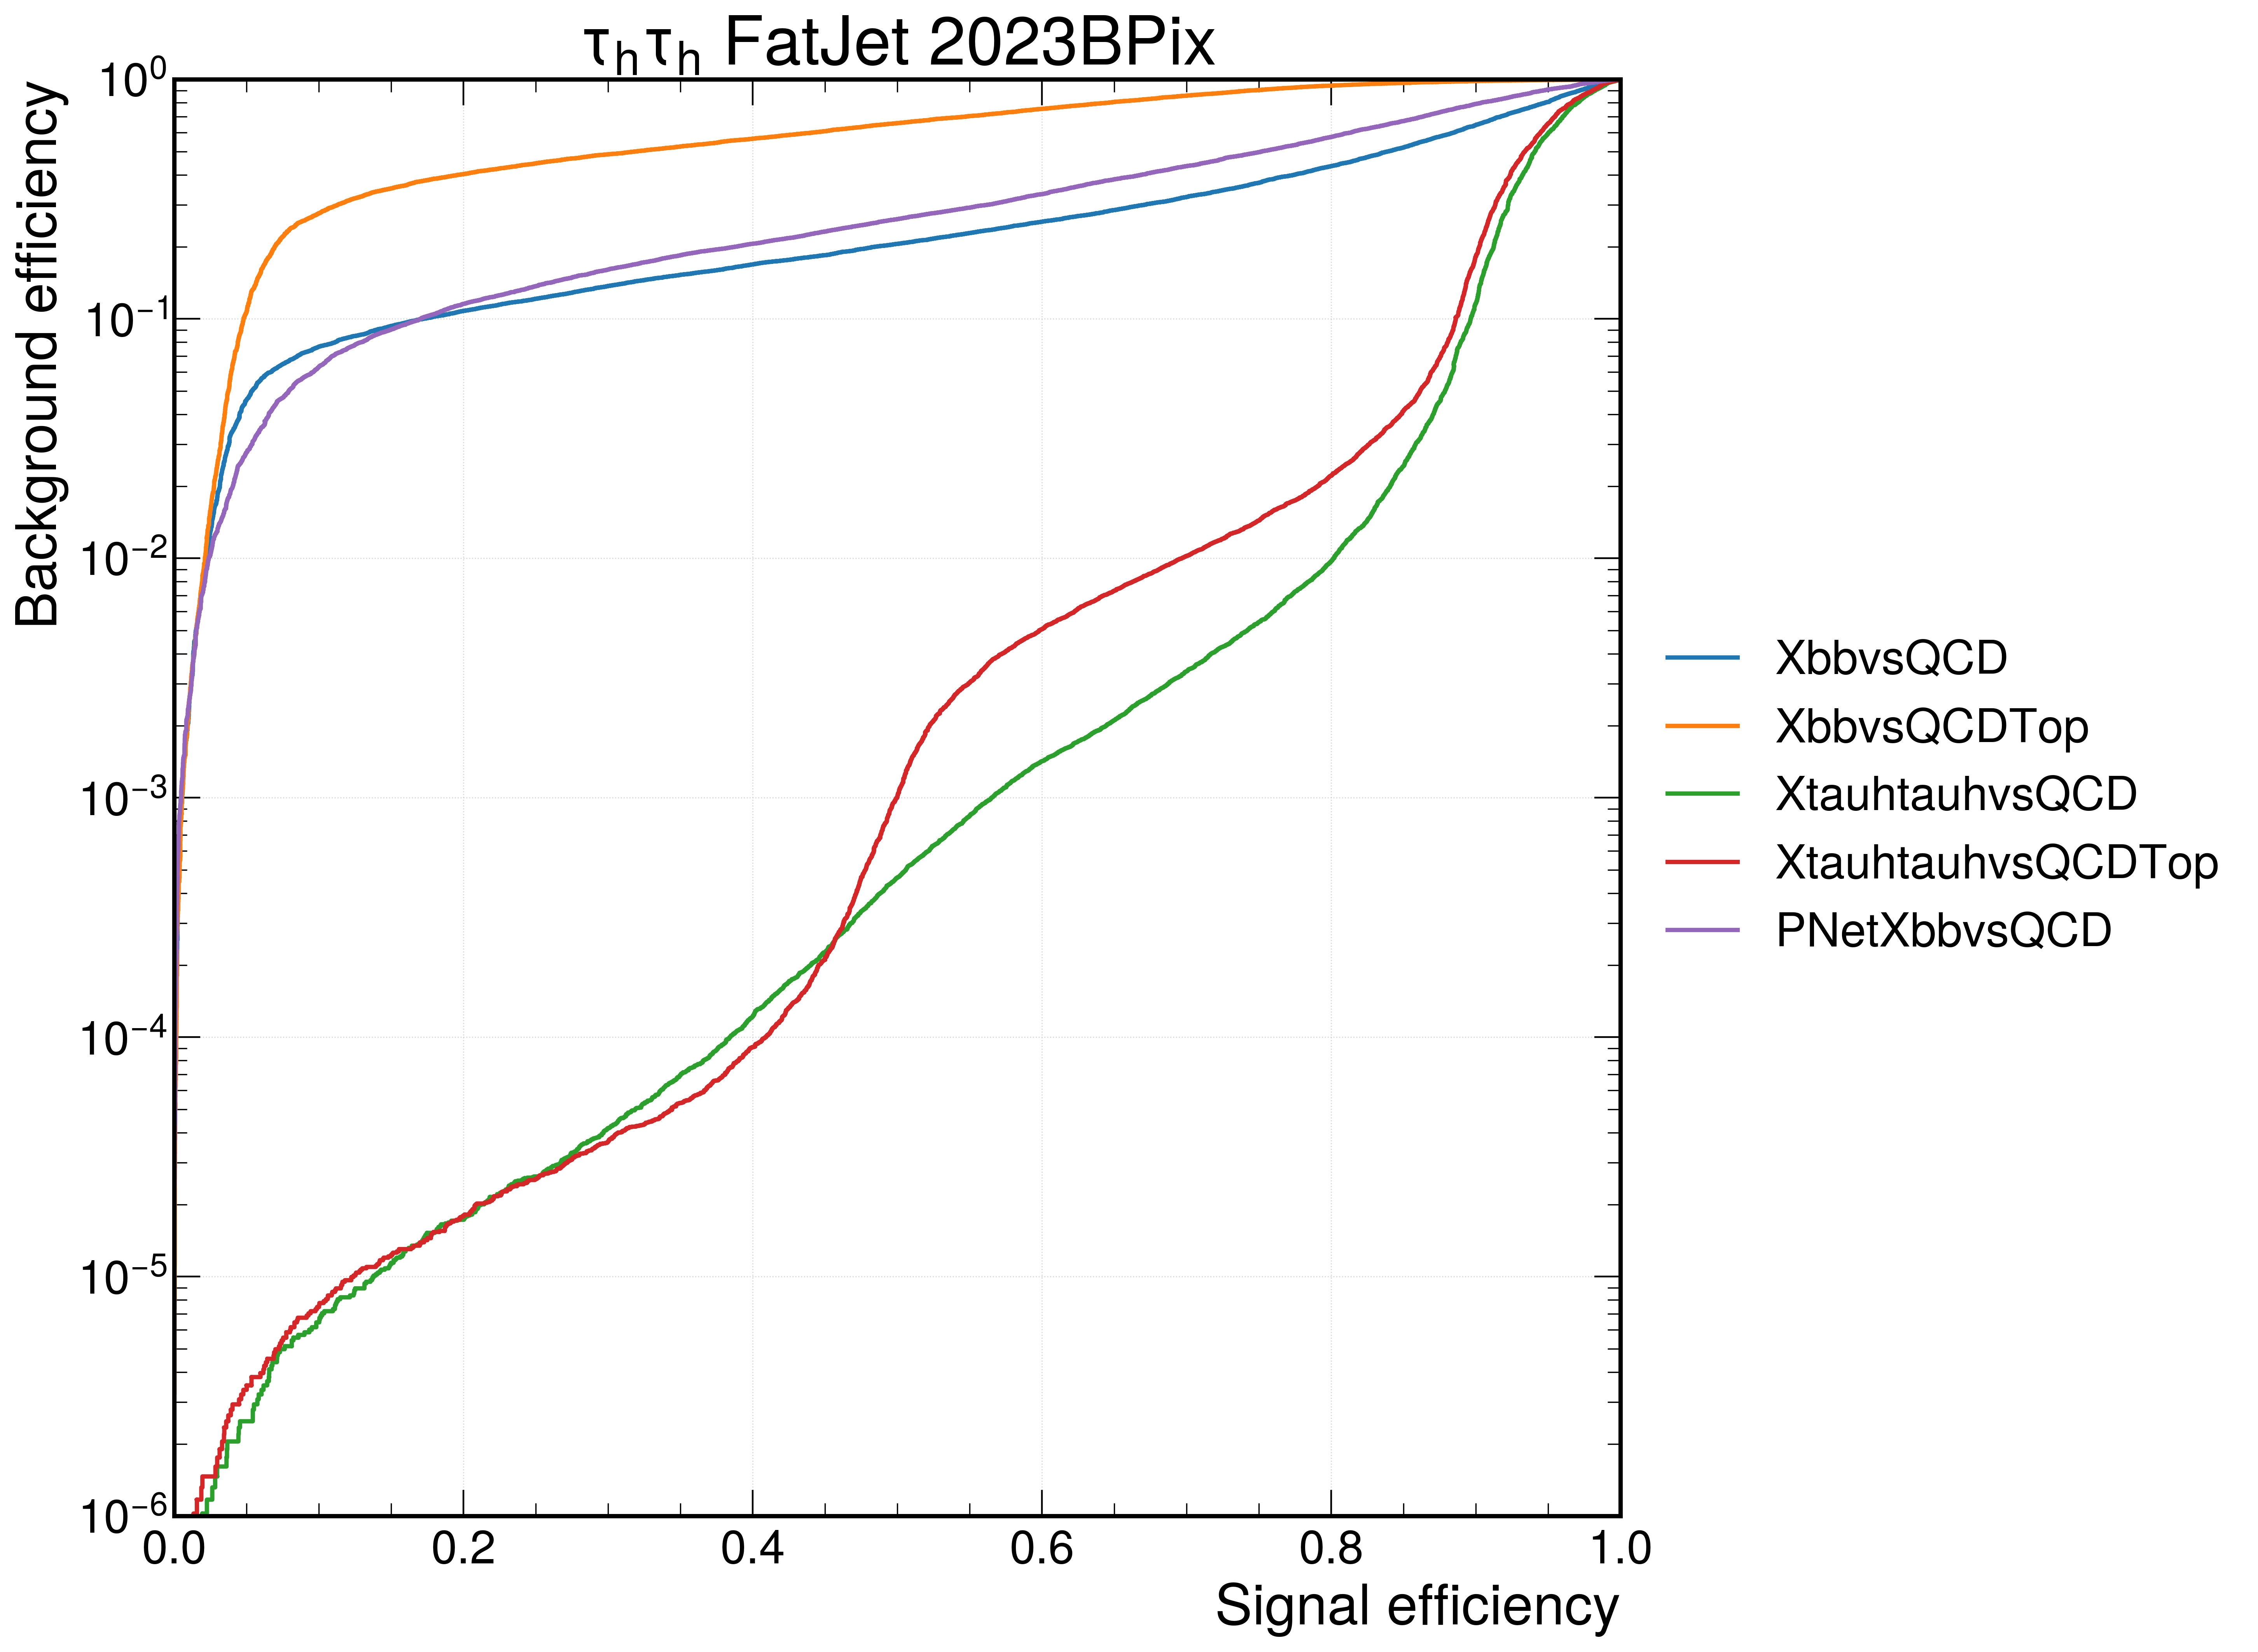

In [ ]:
for year in years:
    for jet, title in zip(["bb", "tautau"], ["bb FatJet", rf"$\tau_h\tau_{CHANNEL[0]}$ FatJet"]):
        plotting.multiROCCurveGrey(
            {"": rocs[year][jet]},
            title=title + " " + year,
            show=True,
            plot_dir=plot_dir,
            name=f"roc_{jet} {year}",
        )

## Mass

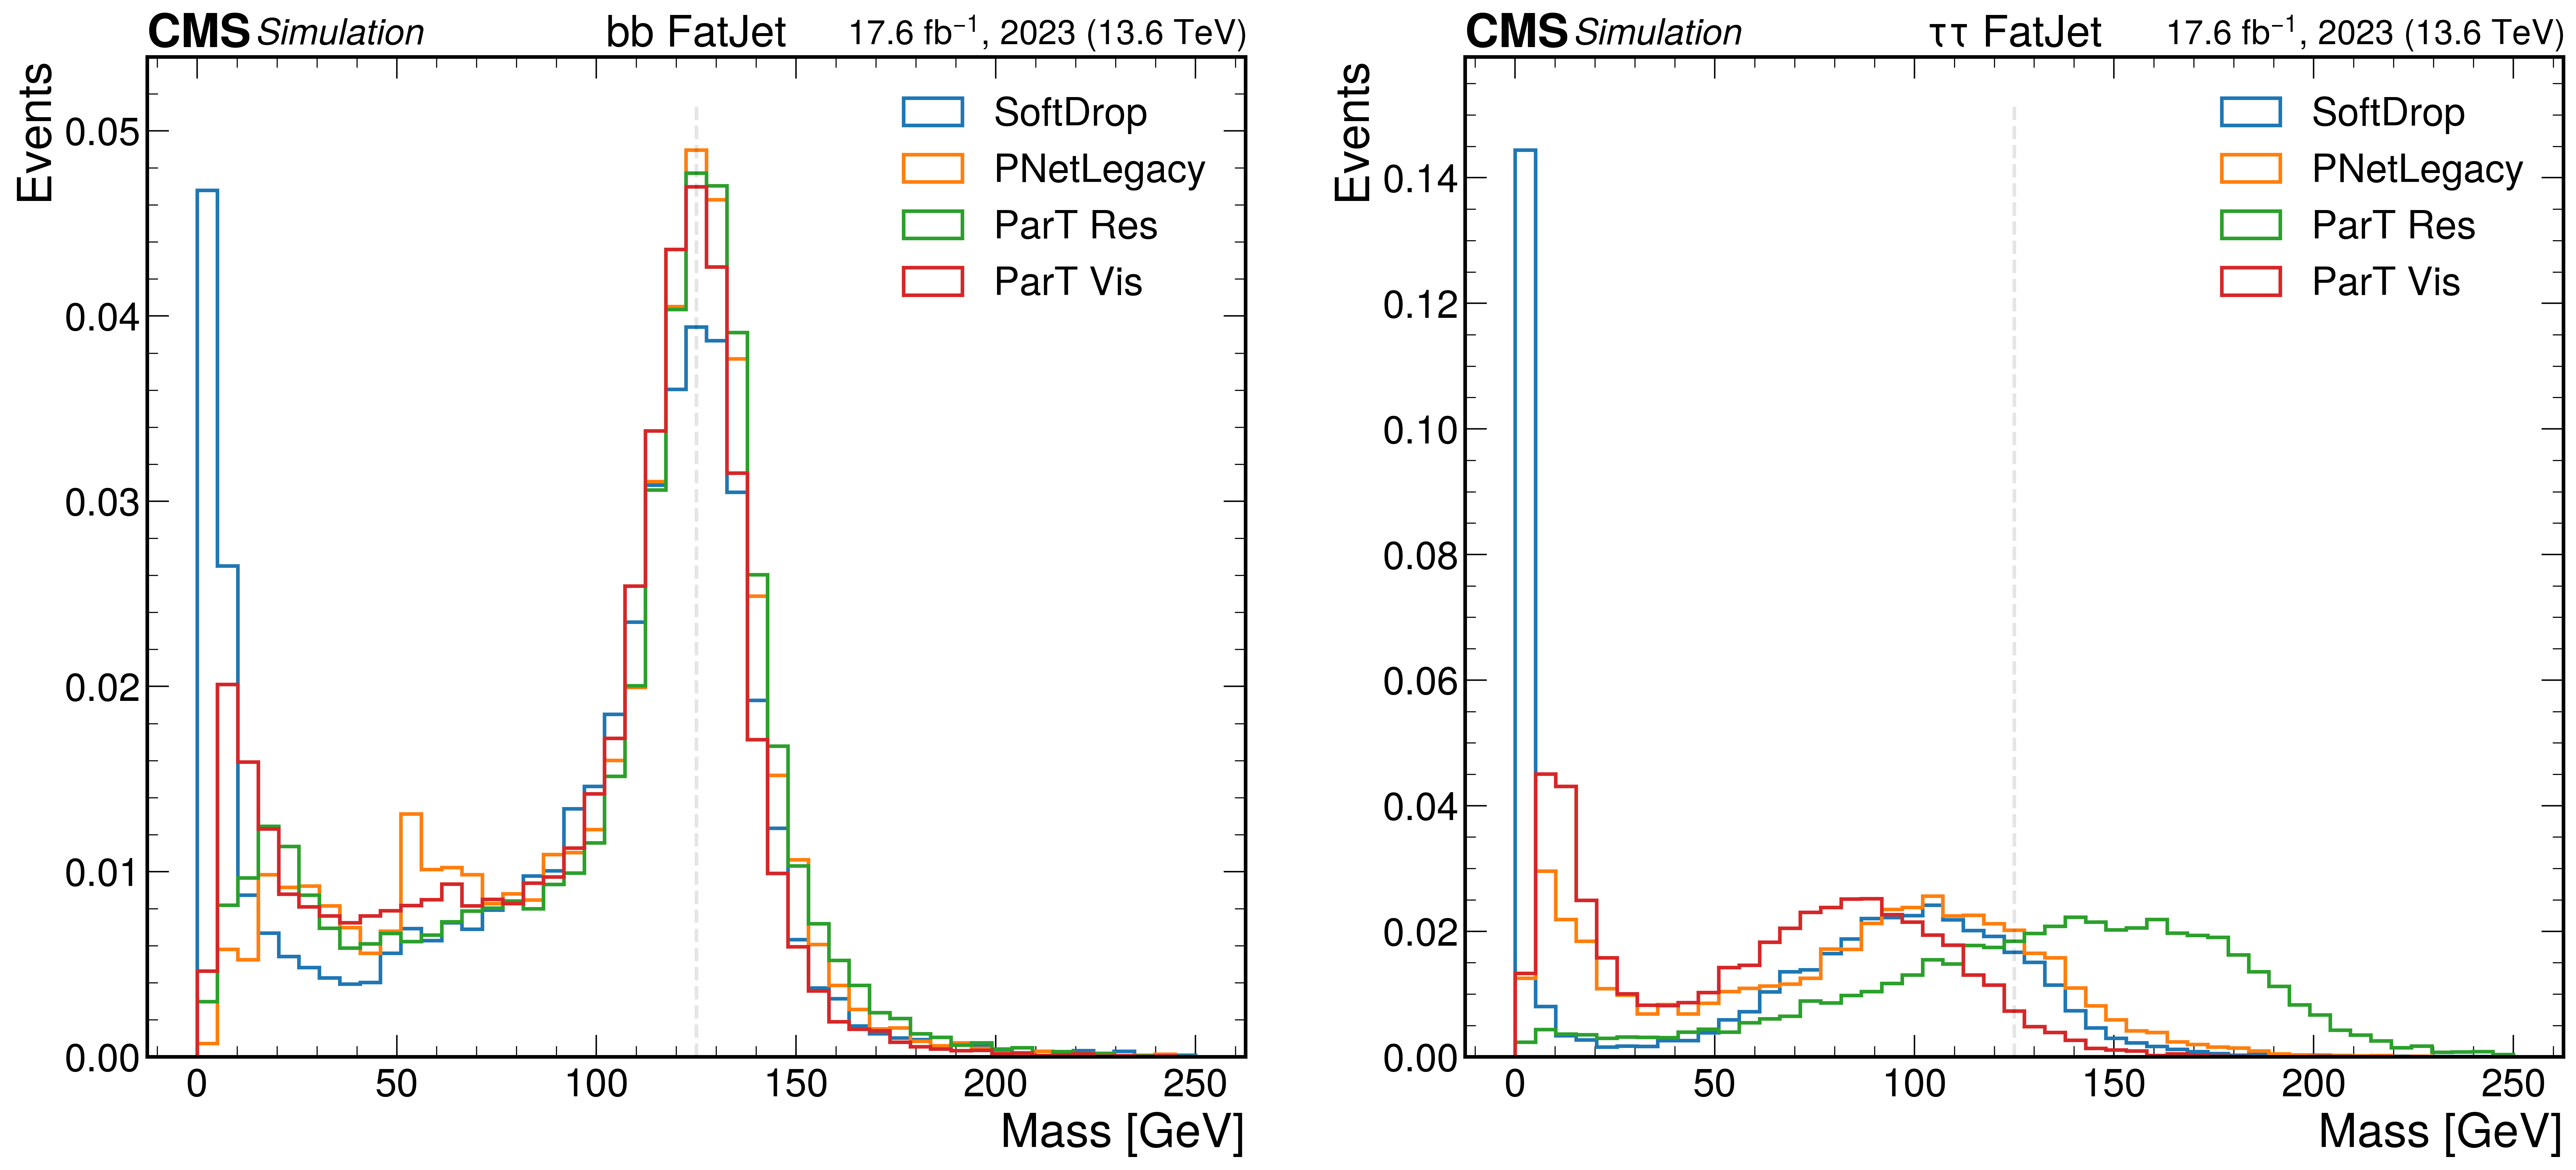

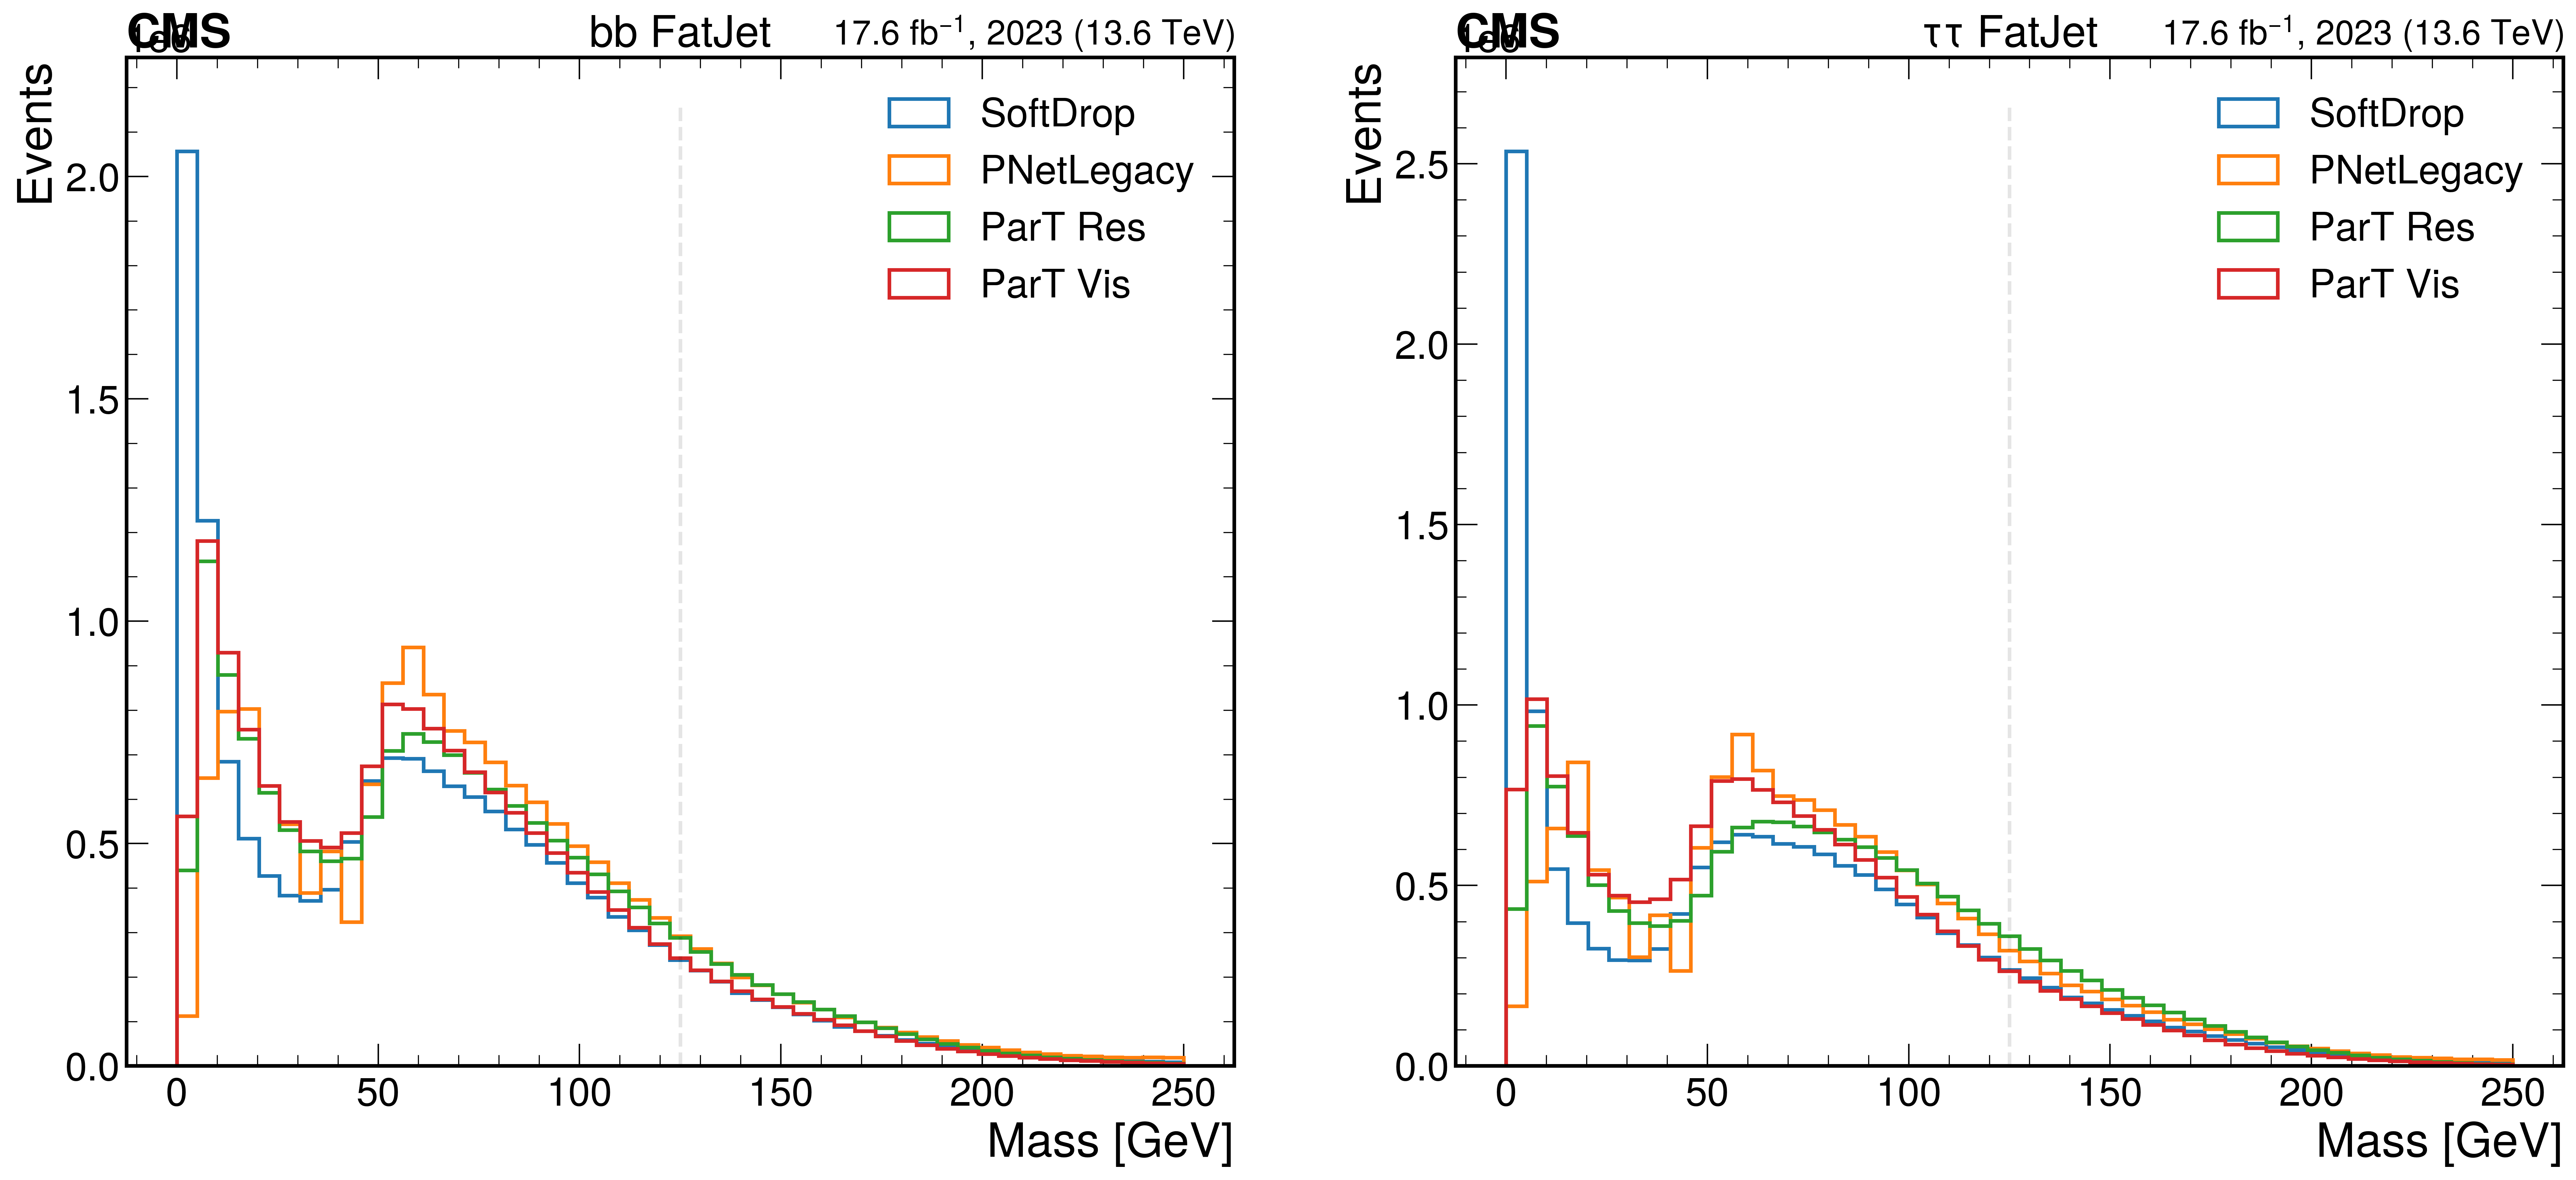

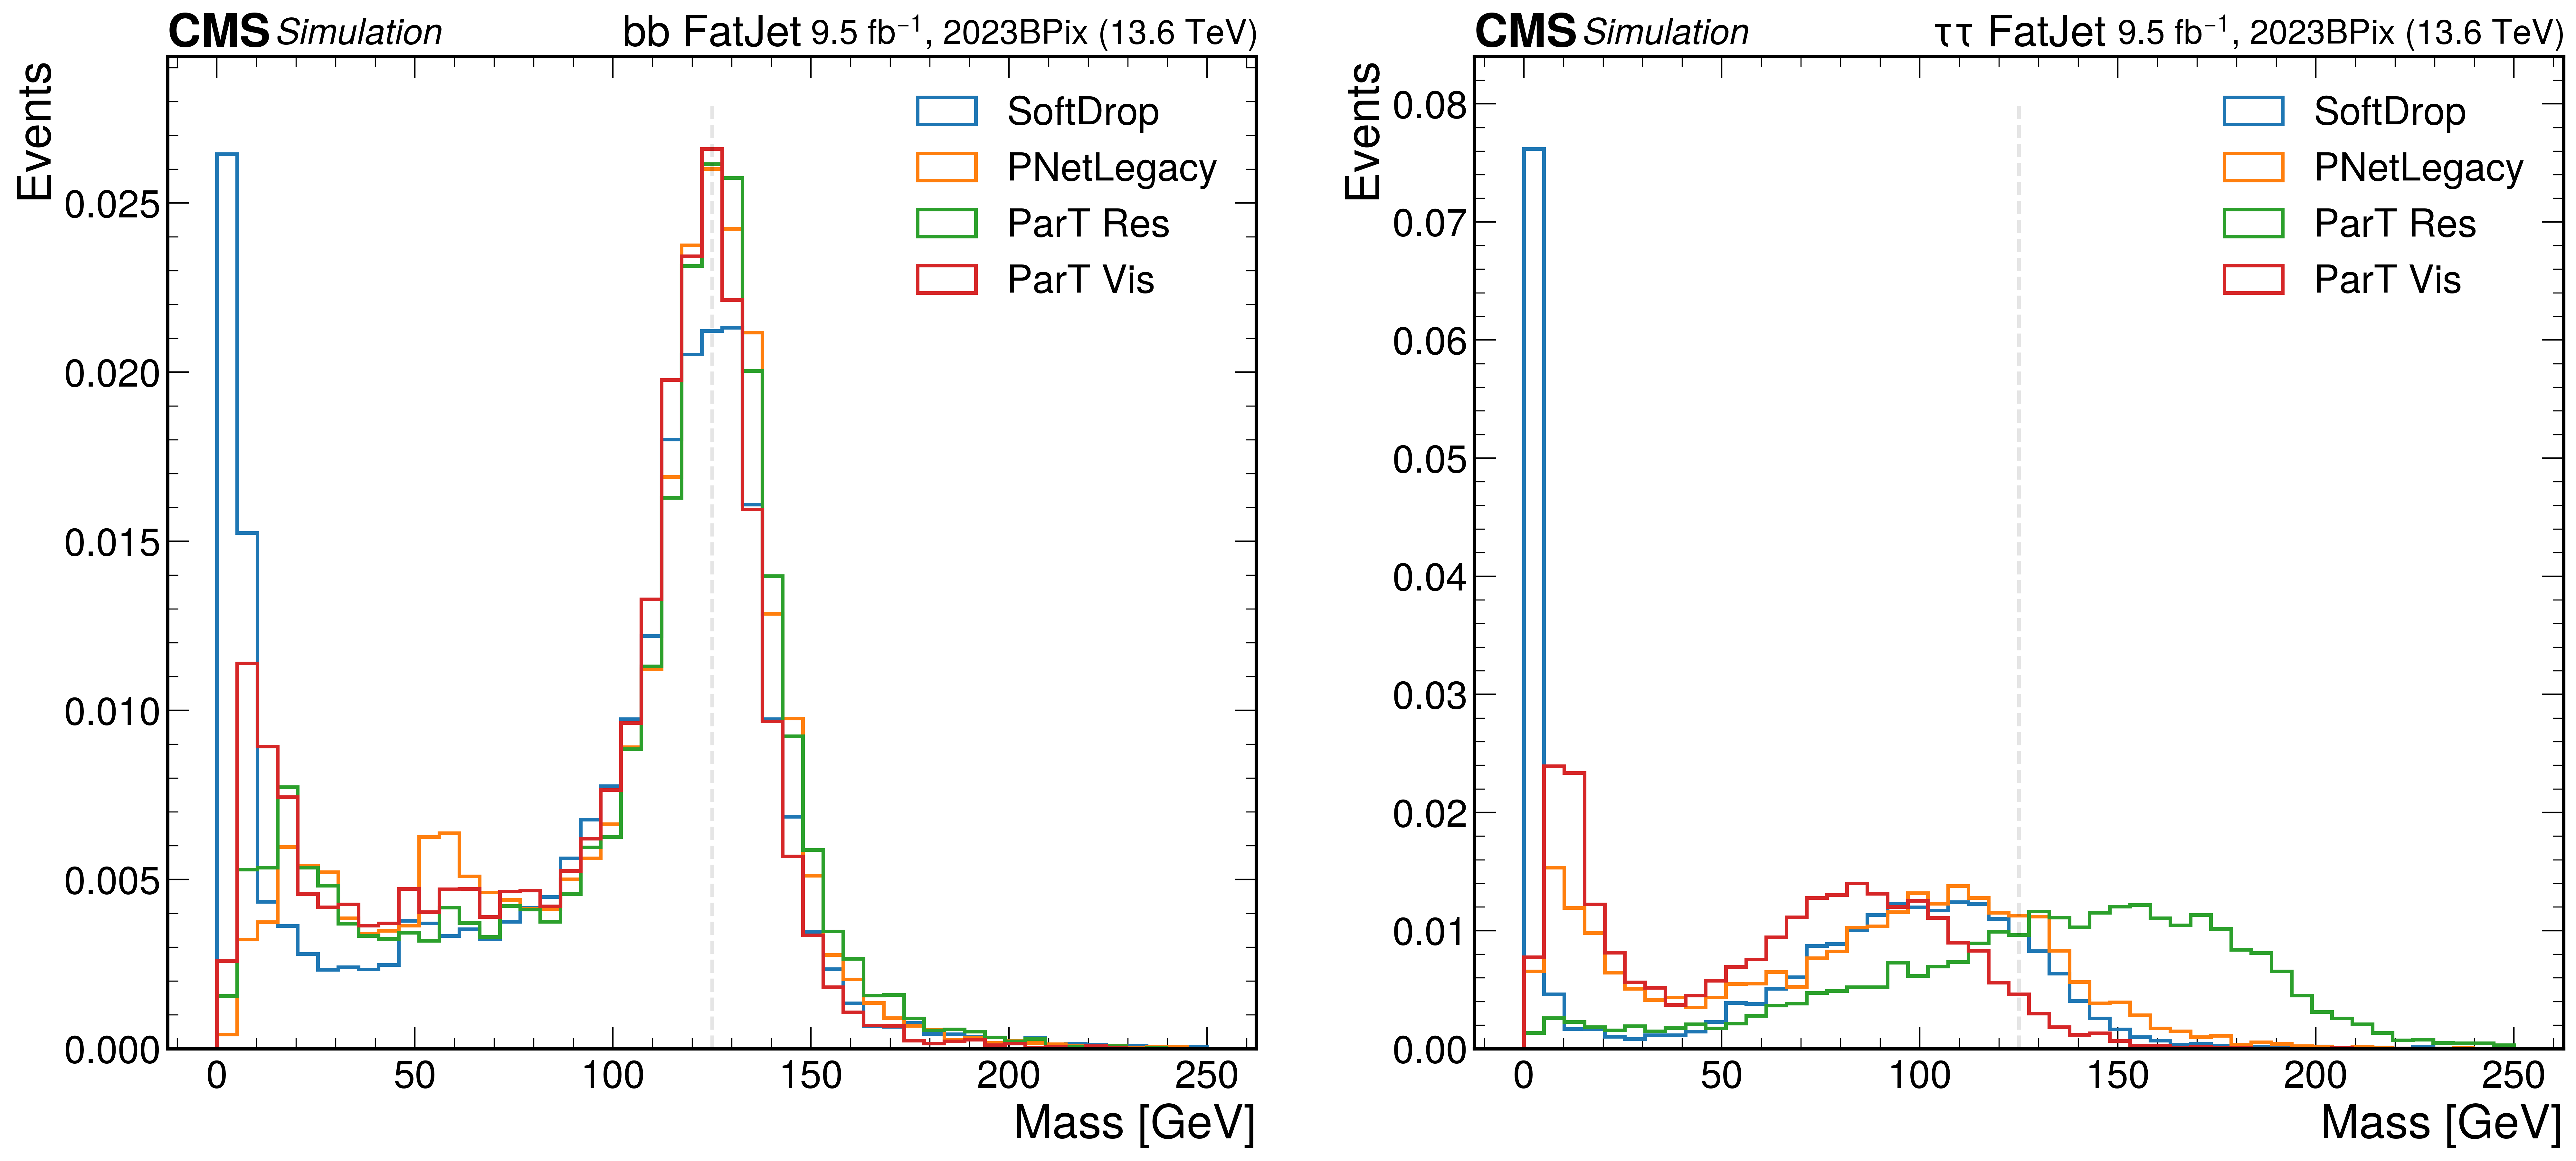

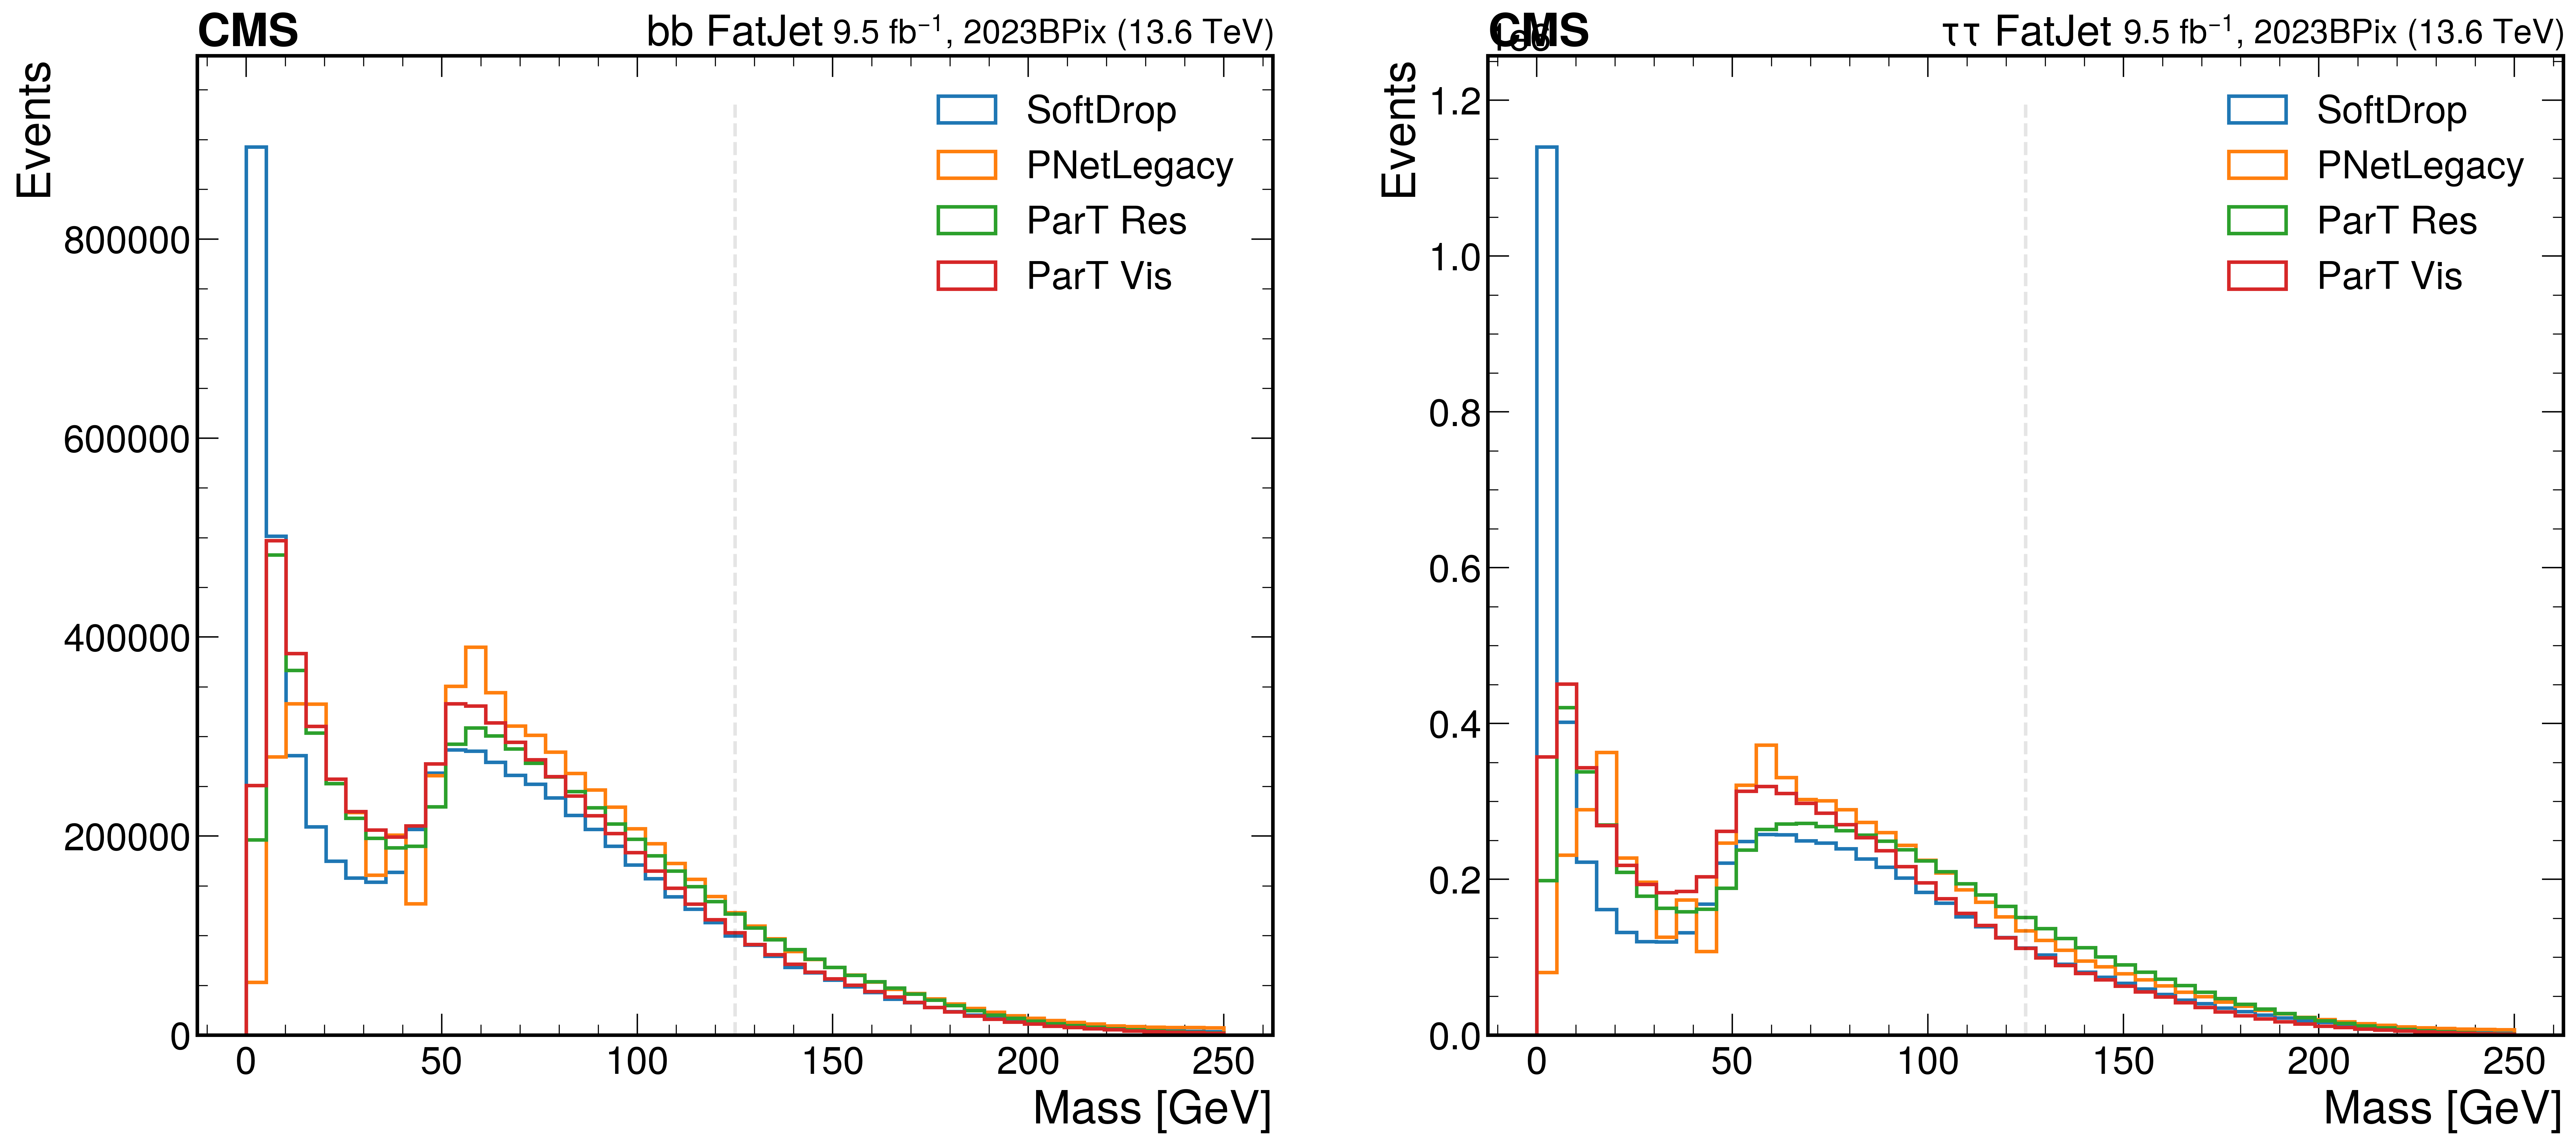

In [ ]:
for year in years:
    for key, label in zip(["hhbbtt", "data"], ["HHbbtt", "Data"]):
        if key == "hhbbtt":
            events = events_dict[year][SIG_KEY]
        else:
            events = pd.concat([events_dict[year][dkey] for dkey in DATA_KEYS])

        bins = np.linspace(0, 250, 50)

        fig, axs = plt.subplots(1, 2, figsize=(24, 10))

        for i, (jet, jlabel) in enumerate(
            zip(["bb", "tautau"], ["bb FatJet", r"$\tau\tau$ FatJet"])
        ):
            ax = axs[i]
            if key == "hhbbtt":
                mask = taggers_dict[year][SIG_KEY][f"{jet}_mask"]
            else:
                mask = np.concatenate(
                    [taggers_dict[year][dkey][f"{jet}_mask"] for dkey in DATA_KEYS], axis=0
                )

            for j, (mkey, mlabel) in enumerate(
                zip(
                    [
                        "ak8FatJetMsd",
                        "ak8FatJetPNetmassLegacy",
                        "ak8FatJetParTmassResApplied",
                        "ak8FatJetParTmassVisApplied",
                    ],
                    ["SoftDrop", "PNetLegacy", "ParT Res", "ParT Vis"],
                )
            ):
                ax.hist(
                    get_jet_vals(events[mkey], mask),
                    bins=bins,
                    histtype="step",
                    weights=events["finalWeight"],
                    label=mlabel,
                    linewidth=2,
                    color=plt.cm.tab10.colors[j],
                )

            ax.vlines(125, 0, ax.get_ylim()[1], linestyle="--", color="k", alpha=0.1)
            ax.set_title(jlabel, fontsize=24)
            ax.set_xlabel("Mass [GeV]")
            # rax.set_xlabel("Mass [GeV]")
            ax.set_ylabel("Events")
            ax.legend()
            ax.set_ylim(0)
            hep.cms.label(
                ax=ax,
                data=key == "data",
                year=year,
                com="13.6",
                fontsize=20,
                lumi=f"{hh_vars.LUMI[year] / 1000:.1f}",
            )

        plt.savefig(plot_dir / f"{key}_{year}_mass.pdf", bbox_inches="tight")
        plt.show()

## Cut-and-count

In [ ]:
from matplotlib.lines import Line2D

# bbeff, tteff = 0.44,0.36 #0.44, 0.36 values determined by highest sig for 1 bkg event
mbb1, mbb2 = 110.0, 160.0
mbbw2 = (mbb2 - mbb1) / 2
mtt1, mtt2 = 50, 1500

# mbbk = "PNetmassLegacy"
mbbk = "ParTmassResApplied"
# mttk = "PNetmassLegacy"
mttk = "ParTmassResApplied"

txbbs = {year: {} for year in years}
txtts = {year: {} for year in years}
masstt = {year: {} for year in years}
massbb = {year: {} for year in years}
ptbb = {year: {} for year in years}

# precompute to speedup
for year in years:
    for key in [SIG_KEY] + DATA_KEYS:
        txbbs[year][key] = get_jet_vals(
            taggers_dict[year][key]["XbbvsQCD"], taggers_dict[year][key]["bb_mask"]
        )
        txtts[year][key] = get_jet_vals(
            taggers_dict[year][key][f"{taukey}vsQCDTop"], taggers_dict[year][key]["tautau_mask"]
        )
        masstt[year][key] = get_jet_vals(
            events_dict[year][key][f"ak8FatJet{mttk}"], taggers_dict[year][key]["tautau_mask"]
        )
        massbb[year][key] = get_jet_vals(
            events_dict[year][key][f"ak8FatJet{mbbk}"], taggers_dict[year][key]["bb_mask"]
        )
        ptbb[year][key] = get_jet_vals(
            events_dict[year][key]["ak8FatJetPt"], taggers_dict[year][key]["bb_mask"]
        )


def compute_sig_bg(year, txbbcut, txttcut, mbb1, mbb2, mbbw2, mtt1, mtt2):
    bg_yield = 0
    sig_yield = 0

    for key in [SIG_KEY] + DATA_KEYS:
        # plt.hist(massbb, np.linspace(0, 200, 100), histtype="step", label=key, weights=events_dict[key]["finalWeight"])
        if key == SIG_KEY:
            cut = (
                (txbbs[year][key] > txbbcut)
                & (txtts[year][key] > txttcut)
                & (masstt[year][key] > mtt1)
                & (masstt[year][key] < mtt2)
                & (massbb[year][key] > mbb1)
                & (massbb[year][key] < mbb2)
                & (ptbb[year][key] > 250)
            )
            sig_yield += np.sum(events_dict[year][key]["finalWeight"][cut])
        else:
            cut = (
                (txbbs[year][key] > txbbcut)
                & (txtts[year][key] > txttcut)
                & (masstt[year][key] > mtt1)
                & (masstt[year][key] < mtt2)
                & (ptbb[year][key] > 250)
            )
            msb1 = (massbb[year][key] > (mbb1 - mbbw2)) & (massbb[year][key] < mbb1)
            msb2 = (massbb[year][key] > mbb2) & (massbb[year][key] < (mbb2 + mbbw2))
            bg_yield += np.sum(events_dict[year][key]["finalWeight"][cut & msb1])
            bg_yield += np.sum(events_dict[year][key]["finalWeight"][cut & msb2])
    return sig_yield, bg_yield


def sig_bkg_opt(year, gridsize=100, gridlims=(0.5, 1), plot=False):
    # bbeff_vals = np.linspace(0.3, 0.7, gridsize)
    # tteff_vals = np.linspace(0.3, 0.7, gridsize)
    bbcut = np.linspace(*gridlims, gridsize)
    ttcut = np.linspace(*gridlims, gridsize)

    BBcut, TTcut = np.meshgrid(bbcut, ttcut)

    # scalar function, must be vectorized
    sig_bg = lambda bbcut, ttcut: compute_sig_bg(
        year=year,
        txbbcut=bbcut,
        txttcut=ttcut,
        # txbbcut=rocs[year]["bb"]["XbbvsQCD"]["thresholds"][
        #     plotting._find_nearest(rocs[years[0]]["bb"]["XbbvsQCD"]["tpr"], bbeff)
        # ],
        # txttcut=rocs[year]["tautau"][f"{taukey}vsQCDTop"]["thresholds"][
        #     plotting._find_nearest(rocs[years[0]]["tautau"][f"{taukey}vsQCDTop"]["tpr"], tteff)
        # ],
        mbb1=mbb1,
        mbb2=mbb2,
        mbbw2=mbbw2,
        mtt1=mtt1,
        mtt2=mtt2,
    )

    sigs, bgs = np.vectorize(sig_bg)(BBcut, TTcut)
    sel = bgs == 1

    if np.sum(sel) == 0:
        n = 2
        while np.sum(sel) == 0:
            sel = (bgs >= 1) & (bgs <= n)
            n += 1
        print(f"Need a finer grid, no region with B=1. I'm extending the region to B in [1,{n}].")

    sel_idcs = np.argwhere(sel)
    sel_sigs = sigs[sel]

    opt_i = np.argmax(sel_sigs)
    max_sig_idx = tuple(sel_idcs[opt_i])
    bbcut_opt, ttcut_opt = BBcut[max_sig_idx], TTcut[max_sig_idx]

    print(bgs)

    if plot:
        fig, ax = plt.subplots(figsize=(8, 8))
        hep.cms.label(
            ax=ax,
            data=True,
            year=year,
            com="13.6",
            fontsize=16,
            lumi=f"{hh_vars.LUMI[year] / 1000:.1f}",
        )
        sigmap = ax.contourf(BBcut, TTcut, sigs, levels=10, cmap="viridis")
        contour = ax.contour(BBcut, TTcut, sel, colors="r")
        proxy = Line2D([0], [0], color="r", label="B=1 level")
        ax.scatter(bbcut_opt, ttcut_opt, color="r", label="Optimal cut")
        ax.set_xlabel("Xbb vs QCD cut")
        ax.set_ylabel("Xtauhtauh vs QCD cut")
        cbar = plt.colorbar(sigmap, ax=ax)
        cbar.set_label("Signal yield")
        handles, labels = ax.get_legend_handles_labels()
        handles.append(proxy)
        ax.legend(handles=handles, loc="lower left")
        plt.savefig(plot_dir / f"sig_bkg_opt_{year}.pdf", bbox_inches="tight")
        plt.savefig(plot_dir / f"sig_bkg_opt_{year}.png", bbox_inches="tight")
        plt.show()

    return sigs[max_sig_idx], bgs[max_sig_idx], [bbcut_opt, ttcut_opt]


def print_nicely(sig_yield, bg_yield, years):
    print(
        f"""
        
        Yield study year(s) {years}:
        
        """
    )

    print("Sig yield", sig_yield)
    print("BG yield", bg_yield)
    print("limit", 2 * np.sqrt(bg_yield) / sig_yield)

    if "2023" not in years or "2023BPix" not in years:
        print(
            "limit scaled to 22-23 all channels",
            2
            * np.sqrt(bg_yield)
            / sig_yield
            / np.sqrt(
                hh_vars.LUMI["2022-2023"] / np.sum([hh_vars.LUMI[year] for year in years]) * 3
            ),
        )
    print(
        "limit scaled to 22-24 all channels",
        2
        * np.sqrt(bg_yield)
        / sig_yield
        / np.sqrt(
            (124000 + hh_vars.LUMI["2022-2023"])
            / np.sum([hh_vars.LUMI[year] for year in years])
            * 3
        ),
    )
    print(
        "limit scaled to Run 3 all channels",
        2 * np.sqrt(bg_yield) / sig_yield / np.sqrt((360000) / hh_vars.LUMI[year] * 3),
    )
    return


def as_df(sig_yield, bg_yield, years):
    limits = {}

    limits["Sig_Yield"] = sig_yield
    limits["BG_Yield"] = bg_yield
    limits["Limit"] = 2 * np.sqrt(bg_yield) / sig_yield

    if "2023" not in years and "2023BPix" not in years:
        limits["Limit_scaled_22_23"] = (
            2
            * np.sqrt(bg_yield)
            / sig_yield
            / np.sqrt(
                hh_vars.LUMI["2022-2023"] / np.sum([hh_vars.LUMI[year] for year in years]) * 3
            )
        )
    else:
        limits["Limit_scaled_22_23"] = np.nan

    limits["Limit_scaled_22_24"] = (
        2
        * np.sqrt(bg_yield)
        / sig_yield
        / np.sqrt(
            (124000 + hh_vars.LUMI["2022-2023"])
            / np.sum([hh_vars.LUMI[year] for year in years])
            * 3
        )
    )

    limits["Limit_scaled_Run3"] = (
        2
        * np.sqrt(bg_yield)
        / sig_yield
        / np.sqrt((360000) / np.sum([hh_vars.LUMI[year] for year in years]) * 3)
    )

    df = pd.DataFrame([limits])

    return df

Need a finer grid, no region with B=1. I'm extending the region to B in [1,22].
[[147.  70.   0.]
 [ 56.  21.   0.]
 [  0.   0.   0.]]


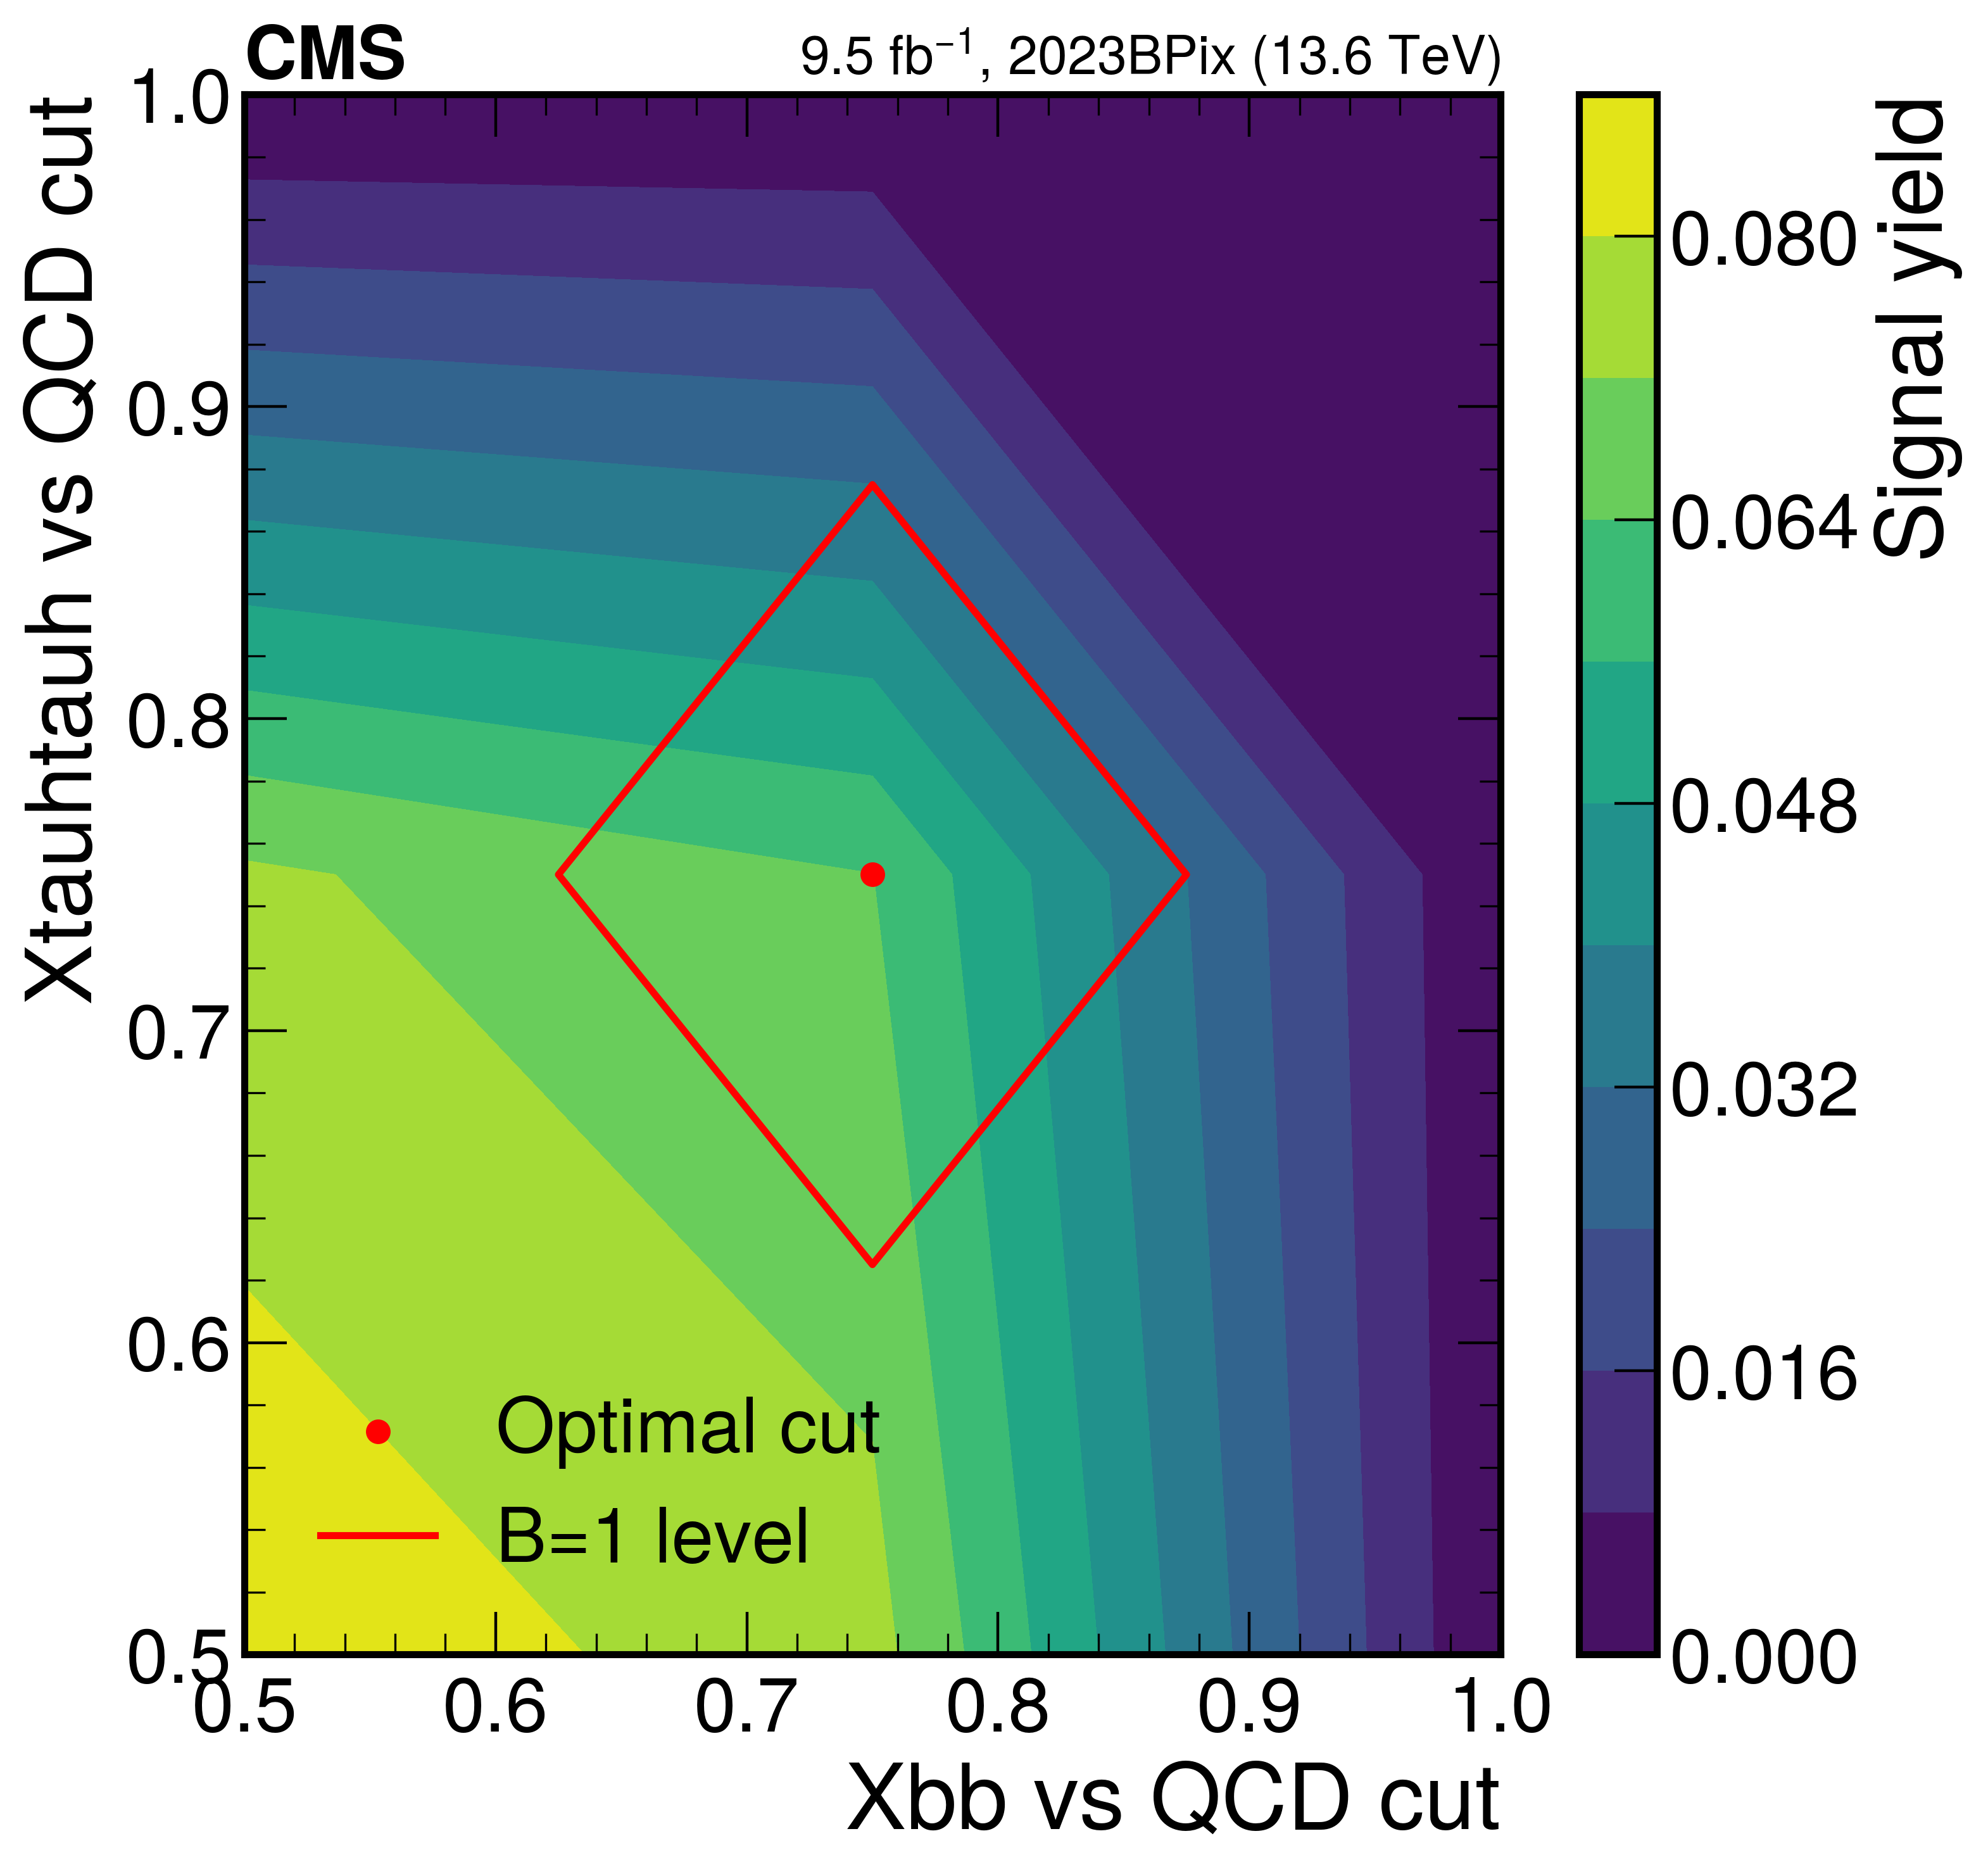

In [ ]:
sig, bkg, [bbcut, ttcut] = sig_bkg_opt("2023BPix", gridsize=3, plot=True)

In [ ]:
# plt.rcdefaults()

In [ ]:
rocs["2023BPix"]["tautau"][f"{taukey}vsQCDTop"]["thresholds"]

array([           inf, 9.99996866e-01, 9.99996866e-01, ...,
       3.51410138e-08, 3.51234880e-08, 1.62393431e-12])

[[281. 268. 252. 242. 228. 215. 203. 197. 182. 164. 161. 151. 142. 133.
  125. 114. 101.  91.  85.  75.  62.  50.  42.  34.  26.  20.  12.   7.
    3.   0.]
 [271. 258. 242. 232. 219. 207. 195. 189. 174. 156. 153. 143. 134. 125.
  118. 107.  95.  86.  80.  70.  58.  47.  41.  33.  26.  20.  12.   7.
    3.   0.]
 [257. 244. 229. 219. 206. 196. 184. 178. 163. 147. 144. 135. 126. 118.
  111. 100.  89.  81.  76.  66.  55.  46.  40.  32.  26.  20.  12.   7.
    3.   0.]
 [244. 231. 218. 208. 196. 187. 176. 170. 156. 140. 137. 128. 119. 112.
  105.  94.  84.  76.  72.  63.  53.  44.  38.  30.  25.  19.  11.   7.
    3.   0.]
 [239. 226. 213. 203. 191. 182. 171. 165. 151. 135. 132. 123. 114. 107.
  101.  90.  80.  72.  68.  59.  49.  41.  35.  28.  23.  18.  11.   7.
    3.   0.]
 [229. 216. 204. 196. 185. 176. 165. 159. 147. 131. 128. 119. 110. 104.
   98.  87.  77.  69.  65.  58.  48.  40.  34.  27.  23.  18.  11.   7.
    3.   0.]
 [213. 202. 193. 185. 174. 165. 154. 148. 136. 122. 120. 1

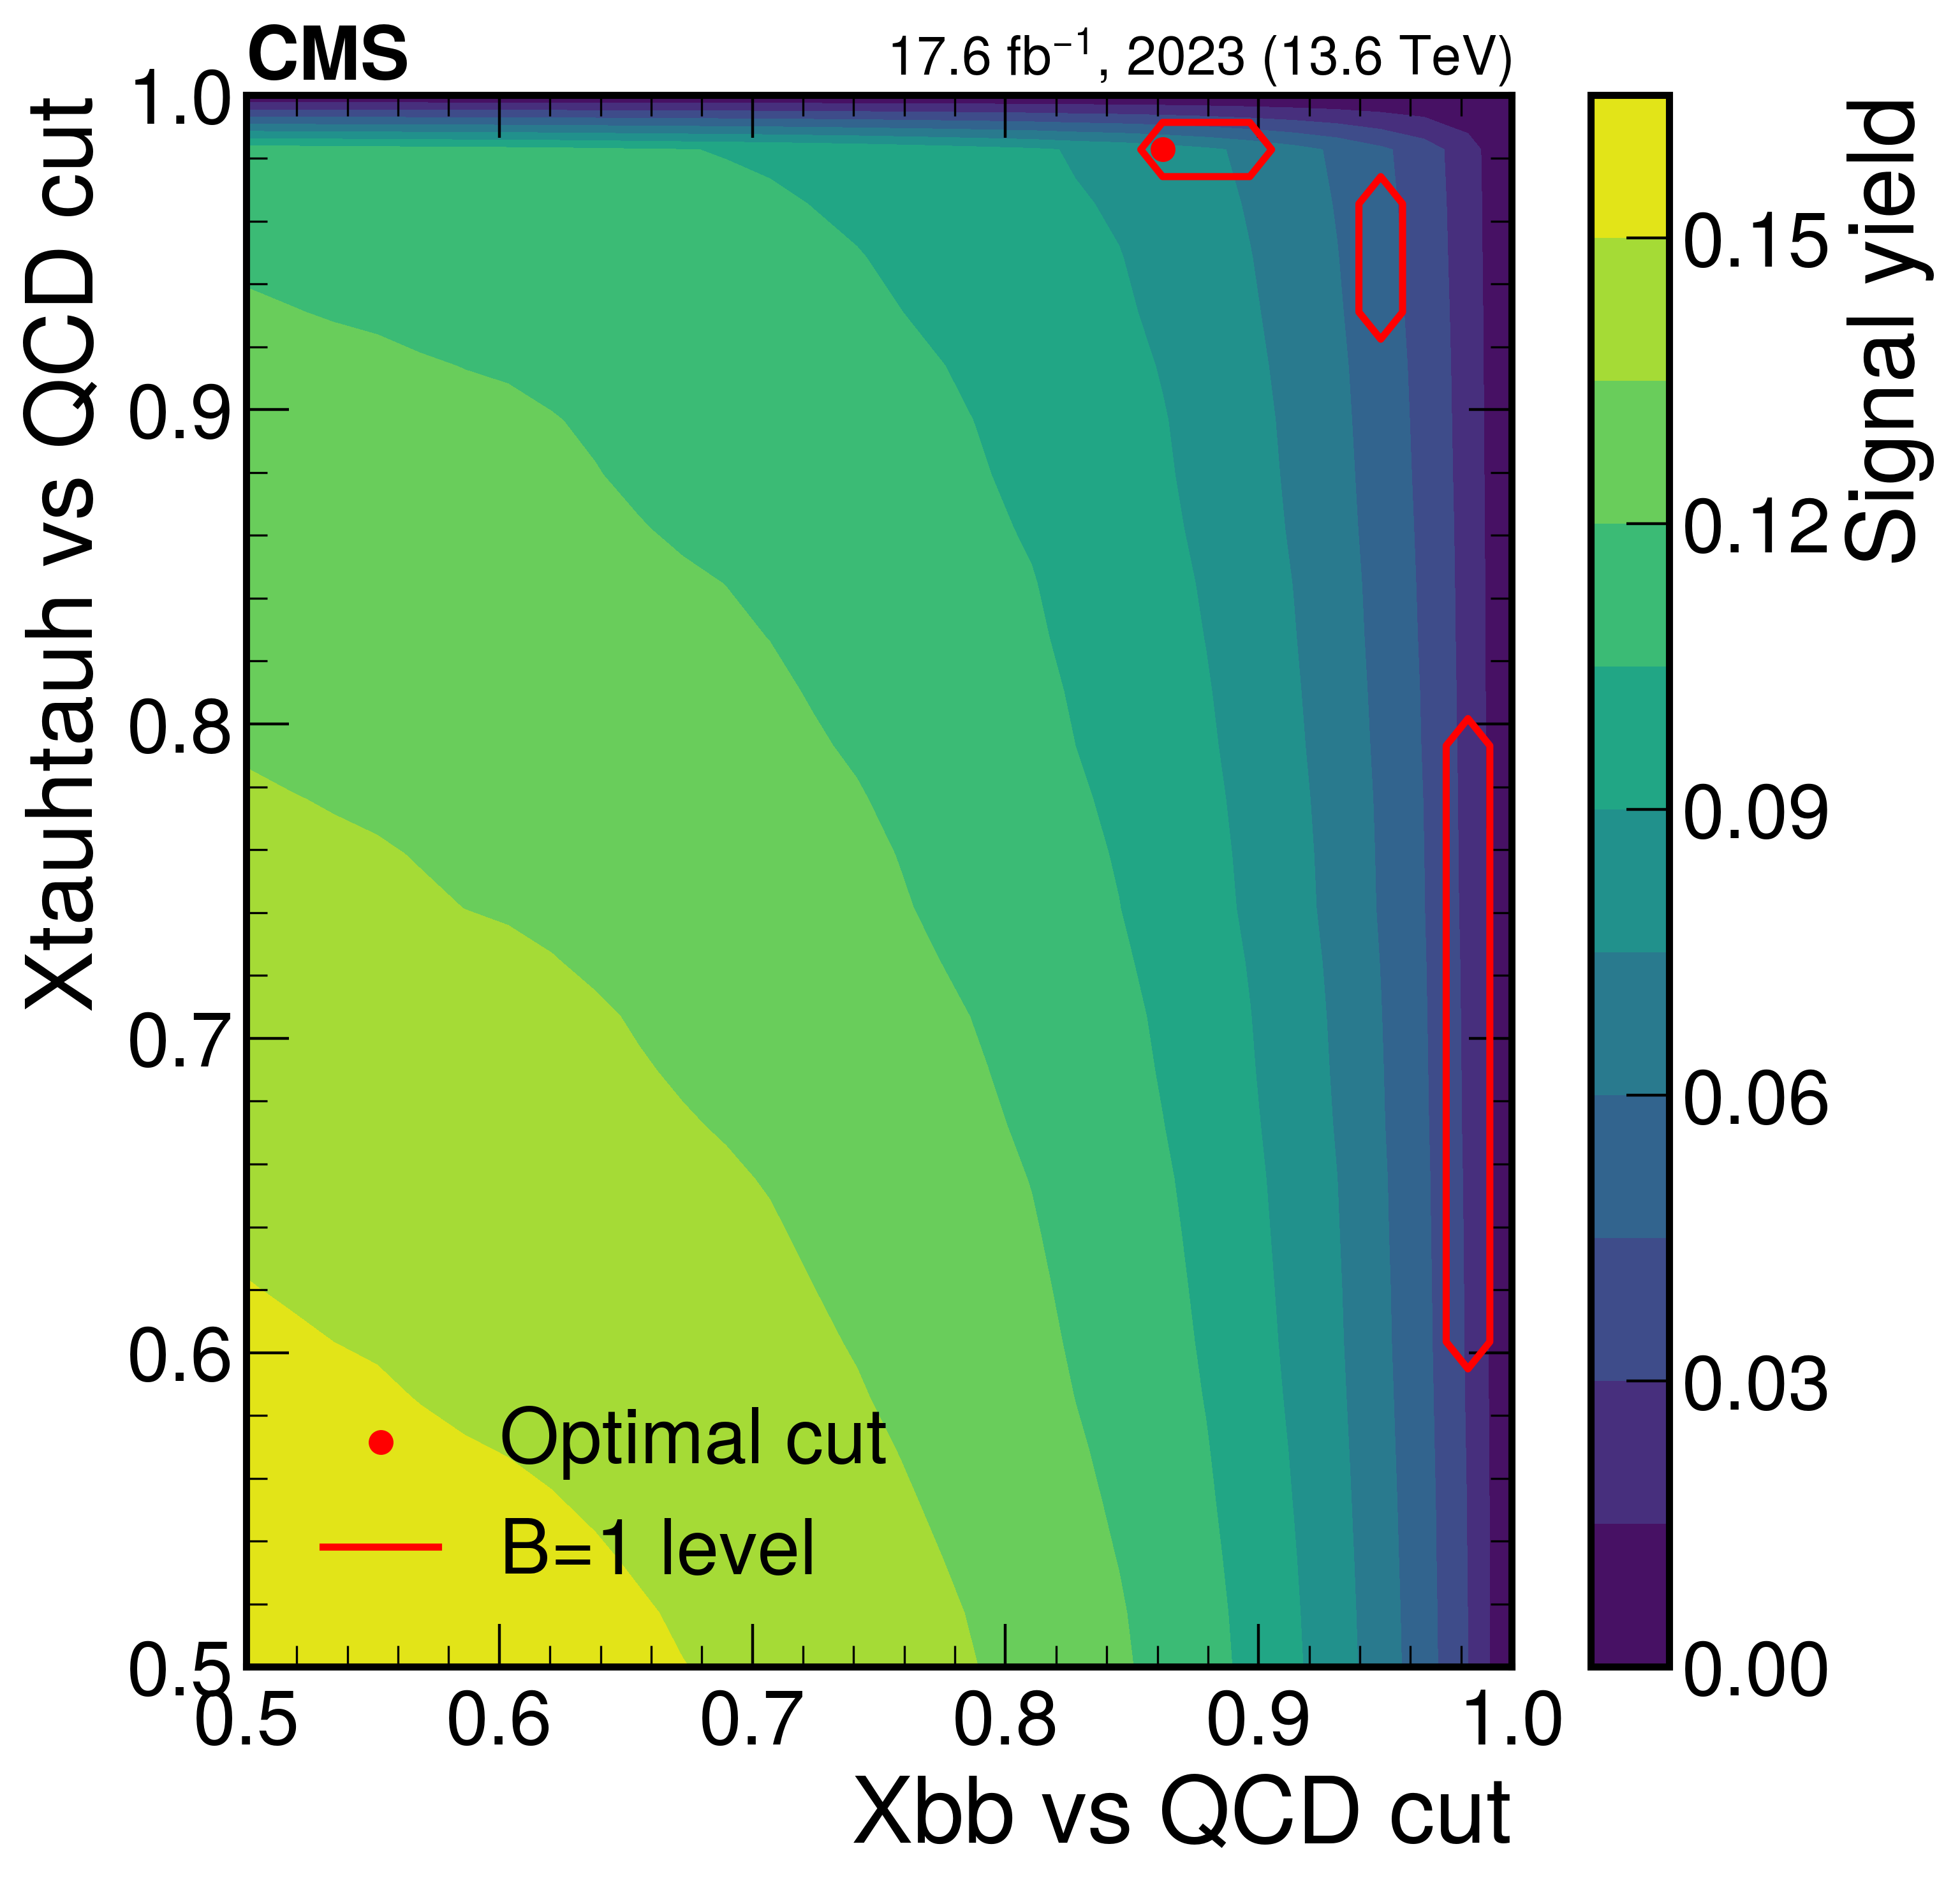

[[147. 144. 137. 130. 128. 123. 118. 114. 111. 104.  95.  91.  84.  77.
   73.  67.  61.  56.  47.  44.  39.  35.  29.  24.  18.  11.   6.   1.
    0.   0.]
 [137. 134. 128. 121. 119. 114. 110. 107. 104.  98.  90.  86.  79.  72.
   68.  62.  57.  52.  44.  41.  37.  33.  27.  22.  17.  11.   6.   1.
    0.   0.]
 [124. 121. 115. 109. 107. 103.  99.  96.  93.  87.  79.  75.  68.  61.
   57.  51.  49.  44.  39.  36.  32.  28.  22.  19.  16.  10.   5.   1.
    0.   0.]
 [116. 113. 107. 102. 100.  96.  92.  89.  86.  80.  72.  68.  61.  55.
   53.  47.  46.  41.  36.  34.  30.  26.  20.  18.  15.  10.   5.   1.
    0.   0.]
 [112. 109. 104. 100.  98.  94.  90.  87.  84.  78.  71.  67.  60.  54.
   52.  46.  45.  40.  35.  33.  29.  25.  19.  17.  14.   9.   4.   1.
    0.   0.]
 [109. 106. 101.  97.  95.  91.  87.  84.  81.  75.  68.  64.  57.  51.
   49.  43.  42.  37.  32.  30.  27.  24.  18.  16.  13.   9.   4.   1.
    0.   0.]
 [101.  98.  93.  89.  88.  84.  81.  78.  75.  70.  63.  

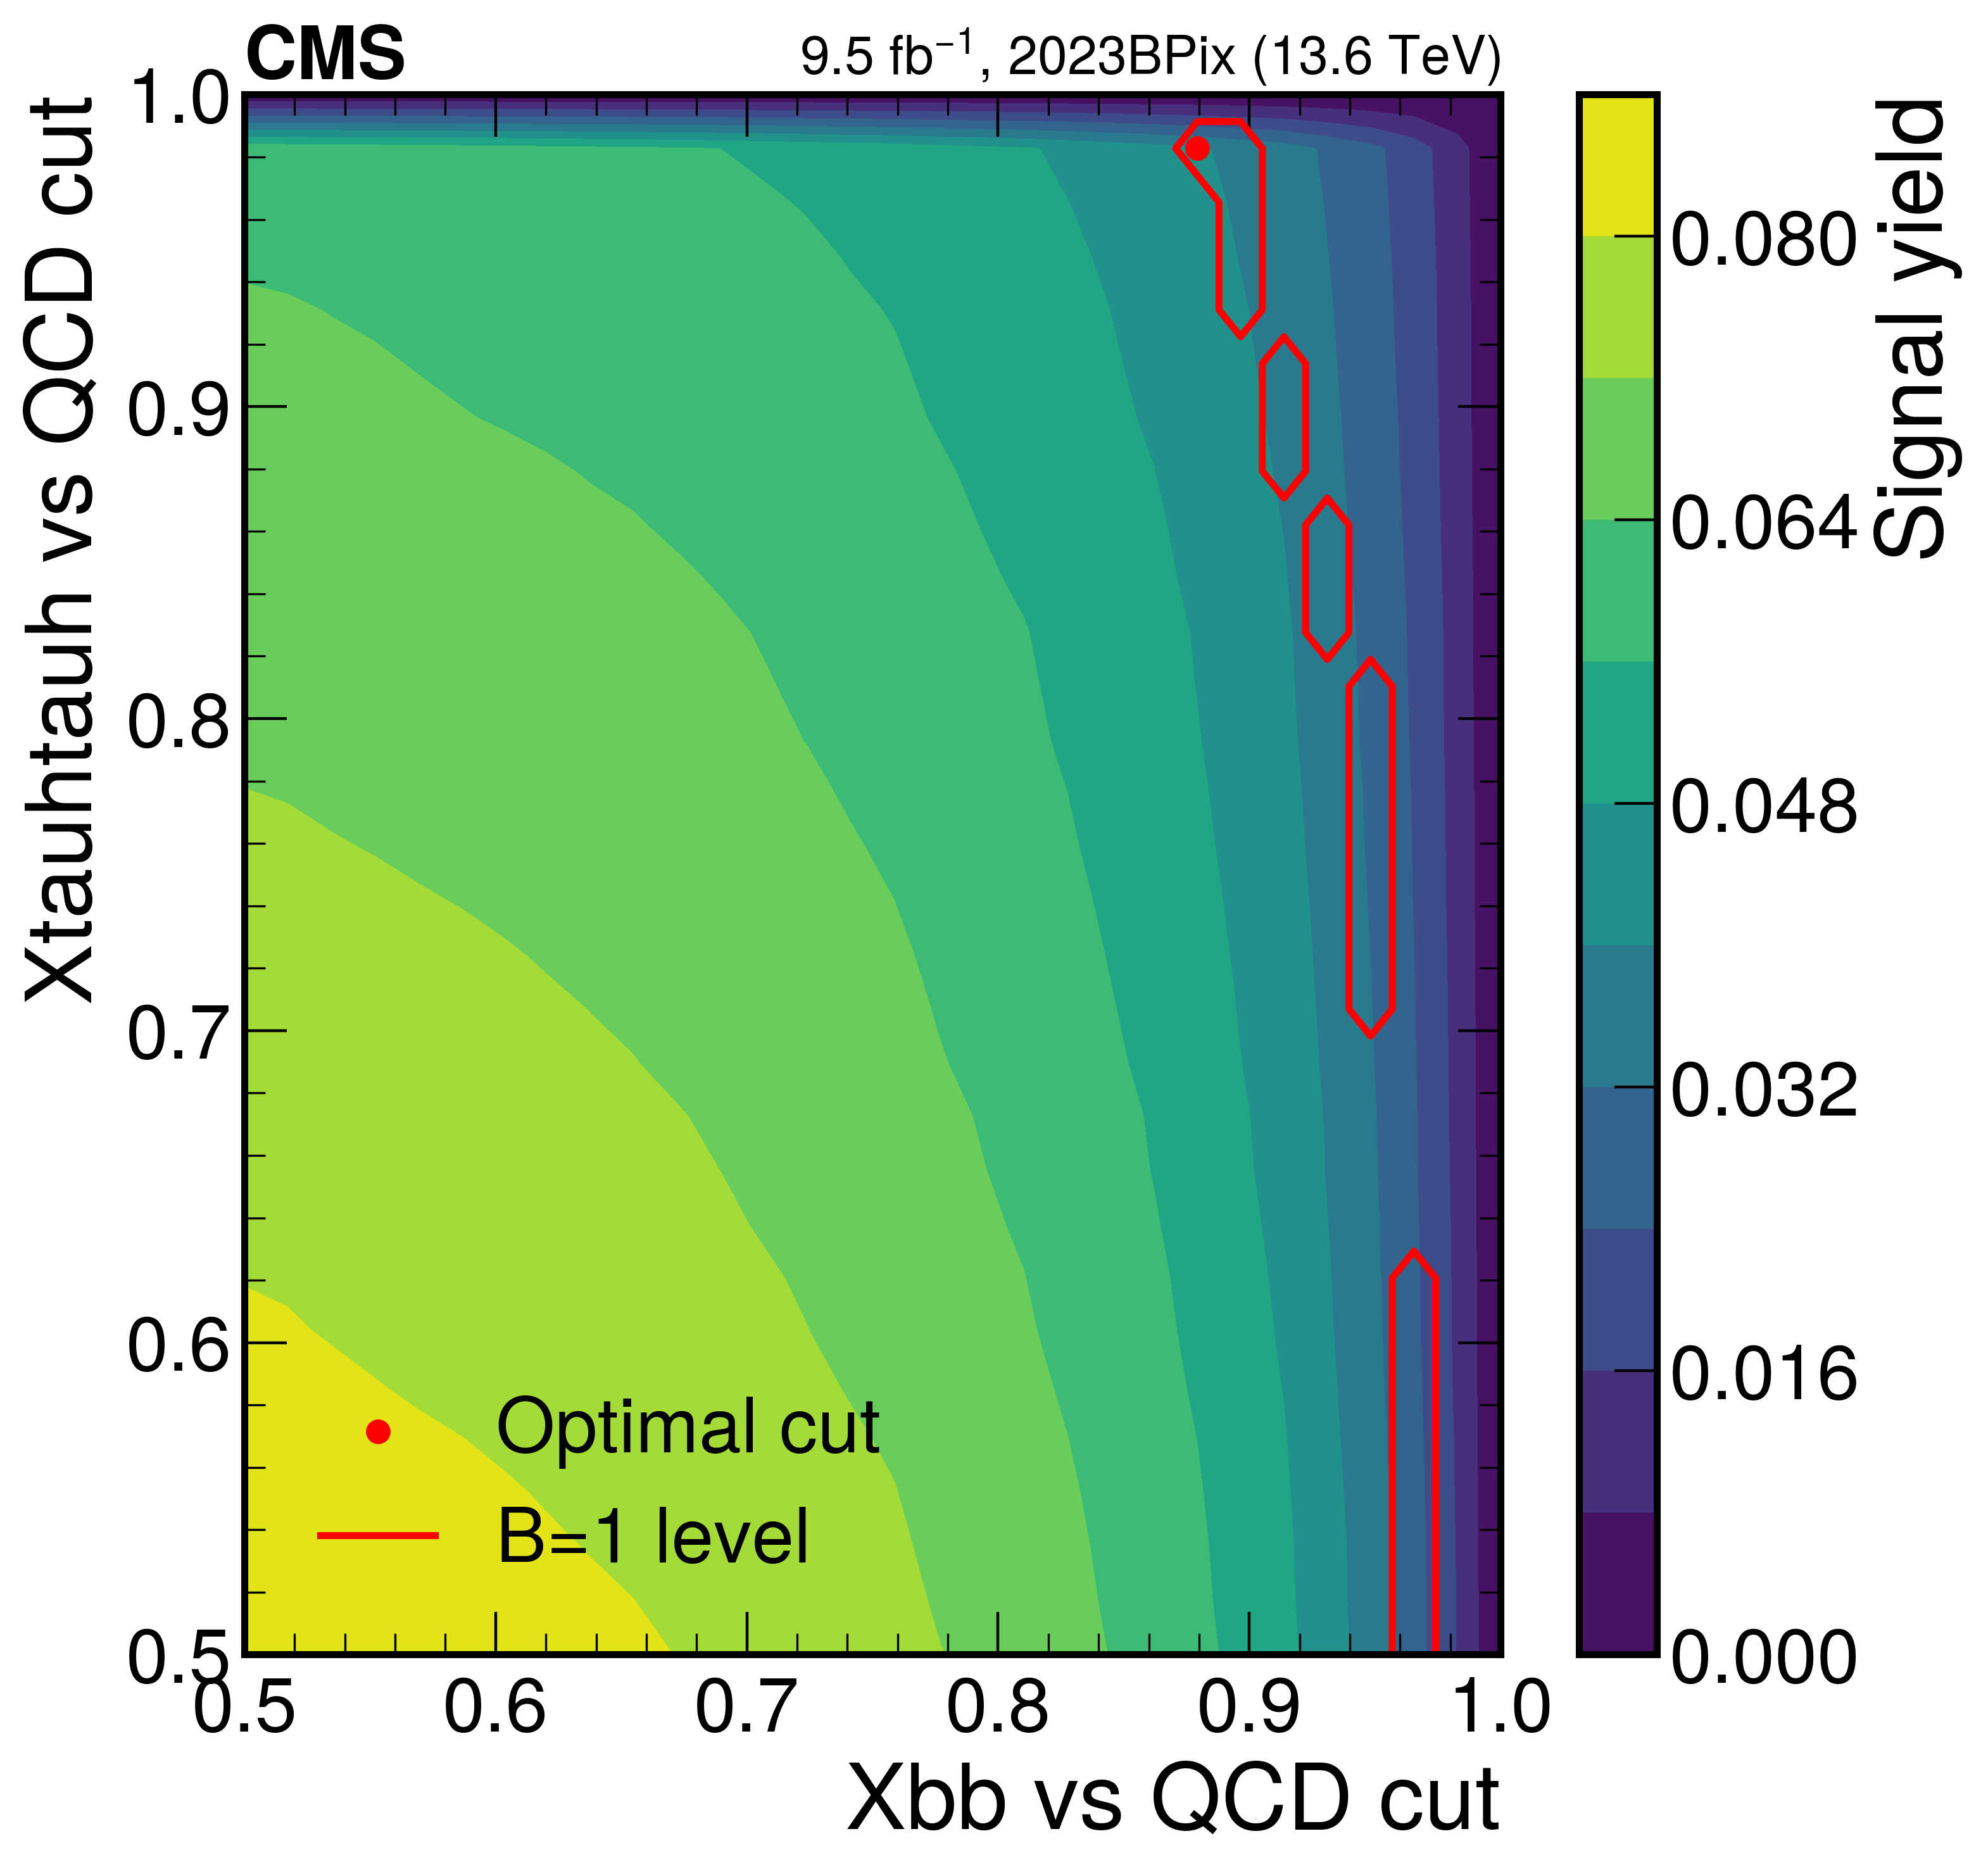

In [ ]:
bg_combined = 0
sig_combined = 0

results = {}

for year in years:
    sig_yield, bkg_yield, [bbcut, ttcut] = sig_bkg_opt(year, gridsize=30, plot=True)
    results[year] = as_df(sig_yield, bkg_yield, [year])
    bg_combined += bkg_yield
    sig_combined += sig_yield

results["Combined"] = as_df(sig_combined, bg_combined, years)

In [ ]:
results_df = pd.concat(results, axis=0)
results_df.index = results_df.index.droplevel(1)
print(results_df.T.to_markdown())
results_df.T.to_csv(plot_dir / f"{years}-results.csv")

|                    |        2023 |    2023BPix |   Combined |
|:-------------------|------------:|------------:|-----------:|
| Sig_Yield          |   0.0822538 |   0.0409074 |   0.123161 |
| BG_Yield           |   1         |   1         |   2        |
| Limit              |  24.315     |  48.8909    |  22.9652   |
| Limit_scaled_22_23 | nan         | nan         | nan        |
| Limit_scaled_22_24 |   4.33132   |   6.37295   |   5.06918  |
| Limit_scaled_Run3  |   3.10838   |   4.57357   |   3.63791  |


| Muons                   |        2023 |    2023BPix |    Combined |
|:-------------------|------------:|------------:|------------:|
| Sig_Yield          |   0.0305736 |   0.0150834 |   0.0456569 |
| BG_Yield           |   1         |   0         |   1         |
| Limit              |  65.416     |   0         |  43.805     |
| Limit_scaled_22_23 | nan         | nan         | nan         |
| Limit_scaled_22_24 |  11.6528    |   0         |   9.66919   |
| Limit_scaled_Run3  |   8.36266   |   0         |   6.93912   |

| **Period (Electrons)**                        | **2022**  | **2022EE** | **Combined (2022, 2022EE)** |
|-------------------------------------|----------:|----------:|---------------------------:|
| **Sig yield**                       | 0.015     | 0.046     | 0.061                     |
| **BG yield**                        | 2.000     | 7.000     | 9.000                     |
| **limit**                           | 190.635   | 115.250   | 98.765                    |
| **limit scaled to 22-23 channels**  | 39.654    | 43.576    | 42.621                    |
| **limit scaled to 22-24 channels**  | 22.821    | 25.078    | 24.529                    |
| **limit scaled to Run 3 channels**  | 16.378    | 17.997    | 17.603                    |


| **Period (Muons)**                        | **2022**  | **2022EE** | **Combined (2022, 2022EE)** |
|-------------------------------------|---------:|----------:|---------------------------:|
| **Sig yield**                       | 0.015    | 0.047     | 0.062                     |
| **BG yield**                        | 0.000    | 3.000     | 3.000                     |
| **limit**                           | 0.000    | 73.528    | 55.506                    |
| **limit scaled to 22-23 channels**  | 0.000    | 27.801    | 23.953                    |
| **limit scaled to 22-24 channels**  | 0.000    | 16.000    | 13.785                    |
| **limit scaled to Run 3 channels**  | 0.000    | 11.482    | 9.893                     |


| **Period (Full hadronic)**                        | **2022**  | **2022EE** | **Combined (2022, 2022EE)** |
|-------------------------------------|---------:|----------:|---------------------------:|
| **Sig yield**                       | 0.032    | 0.104     | 0.136                     |
| **BG yield**                        | 1.000    | 3.000     | 4.000                     |
| **limit**                           | 62.243   | 33.457    | 29.483                    |
| **limit scaled to 22-23 channels**  | 12.947   | 12.650    | 12.723                    |
| **limit scaled to 22-24 channels**  | 7.451    | 7.280     | 7.322                     |
| **limit scaled to Run 3 channels**  | 5.347    | 5.225     | 5.255                     |
